# DCGAN - Deep Convolutional GANs
Tendo sido apresentadas em 2015 por Alec Radford, Luke Metz e Soumith Chintala, as Redes Generativas Adversariais Convolucionais Profundas (Deep Convolutional GANs, ou DCGANs) representaram um marco na aplicação de GANs para geração de imagens sintéticas. Estas redes fazem uso de camadas convolucionais profundas, inspiradas nos princípios de Redes Neurais Convolucionais (CNNs), em ambos os componentes da GAN: o gerador e o discriminador. Tal abordagem permitiu que as DCGANs superassem as arquiteturas tradicionais e produzissem resultados gerativos de melhor qualidade e mais estáveis.

Ao invés de camadas totalmente conectadas, como em outras GANs, as DCGANs são constituídas principalmente de camadas convolucionais, junto a técnicas consagradas do processamento de imagens como pooling, normalização de batch e unidades LSTM. O gerador, especificamente, segue o padrão encoder-decoder: o encoder mapeia o vetor de ruído aleatório de entrada em uma representação latente, que é posteriormente decodificada pelo decoder para formar a imagem sintética.

Graças a essas inovações arquiteturais, as DCGANs foram capazes de gerar, já em 2015, imagens 64x64 com riqueza de detalhes e variabilidade, representando um avanço expressivo em relação às GANs disponíveis anteriormente. As DCGANs abriram caminho para trabalhos ainda mais impactantes nos anos seguintes, como as BigGANs da DeepMind e as StyleGANs da Nvidia. Essa categoria de redes generativas hoje representa o estado da arte para inúmeras tarefas de geração de imagens artificialmente realistas.

# Importação das bibliotecas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.0.0'

# Carregamento e pré-processamento da base de dados

In [2]:
(X_treinamento, y_treinamento), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


In [3]:
X_treinamento.shape

(60000, 28, 28)

In [4]:
28 * 28

784

In [5]:
y_treinamento.shape

(60000,)

3


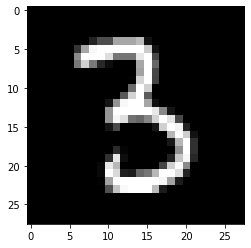

In [6]:
i = np.random.randint(0, 60000)
#print(i)
print(y_treinamento[i])
plt.imshow(X_treinamento[i], cmap = 'gray');

In [7]:
X_treinamento = X_treinamento.reshape(X_treinamento.shape[0], 28, 28, 1).astype('float32')

In [8]:
X_treinamento.shape

(60000, 28, 28, 1)

In [9]:
X_treinamento[0].min(), X_treinamento[0].max()

(0.0, 255.0)

In [10]:
X_treinamento = (X_treinamento - 127.5) / 127.5

In [11]:
X_treinamento[0].min(), X_treinamento[0].max()

(-1.0, 1.0)

In [12]:
buffer_size = 60000
batch_size = 256

In [13]:
buffer_size / batch_size

234.375

In [14]:
type(X_treinamento)

numpy.ndarray

In [15]:
X_treinamento = tf.data.Dataset.from_tensor_slices(X_treinamento).shuffle(buffer_size).batch(batch_size)

In [16]:
type(X_treinamento)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [17]:
X_treinamento

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

# Construção do gerador

- Batch normalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
- Leaky Relu: https://keras.io/api/layers/activation_layers/leaky_relu/
- Funções de ativação: https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e
- Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

In [18]:
7*7*256

12544

## Rede geradora (gerador) para uma GAN. Vamos analisar por partes:

- É utilizado o tf.keras.Sequential() para construir o modelo como uma sequência de camadas.

- A primeira camada Dense cria uma representação latente de 7x7x256 a partir do vetor aleatório de entrada de 100 valores.  

- São utilizadas camadas BatchNorm e LeakyReLU para regularização.

- A camada Reshape molda os dados em um formato 3D (7,7,256).

- A seguir vêm camadas Conv2DTranspose, que fazem upsampling e geram imagens partindo da representação latente.

- Cada camada Conv2DTranspose dobra a resolução da imagem gerada: 
   - A primeira gera imagens de 14x14 pixels
   - A segunda aumenta para 28x28 pixels

- A última camada Conv2DTranspose gera imagens 1 canal, em tanh para flexibilizar a escala de pixel.

Portanto, temos a definição completa de um gerador de GAN que parte de um vetor aleatório e gera imagens 28x28x1.

In [19]:
def cria_gerador():
  network = tf.keras.Sequential()

  network.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding='same', use_bias=False, strides=(2,2)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(filters = 1, kernel_size=(5,5), padding='same',use_bias=False, strides=(2,2), activation = 'tanh'))

  network.summary()

  return network

In [20]:
gerador = cria_gerador()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [21]:
# 100 -> 12544
gerador.input

<tf.Tensor 'dense_input:0' shape=(None, 100) dtype=float32>

In [22]:
ruido = tf.random.normal([1, 100])
ruido

<tf.Tensor: id=470, shape=(1, 100), dtype=float32, numpy=
array([[-1.2970735e+00,  3.4377527e-01, -4.0619445e-01,  2.8704844e-02,
        -1.1932873e+00, -1.0385554e-01, -9.2631519e-01,  2.5823709e-02,
         3.5353112e-01,  1.1277669e-03,  1.7001690e-01,  9.2999965e-01,
         7.4526137e-01,  1.8317996e+00,  7.8305614e-01,  1.0435941e+00,
        -7.4424930e-02, -6.8303639e-01,  7.1680401e-03, -5.8289981e-01,
         5.1480558e-02,  1.0006784e+00, -1.6343840e+00, -7.3558813e-01,
         1.0279442e+00, -1.3337198e+00,  3.5808036e-01,  1.5455278e+00,
         9.0330863e-01,  1.3296510e+00,  3.6432785e-01,  9.6961319e-01,
         2.3599949e+00, -1.3331496e+00, -7.5707918e-01, -2.8595731e-01,
        -4.0047997e-01,  1.0358057e+00,  3.6856666e-01, -1.9673151e+00,
        -1.3628789e+00, -3.6695480e-01,  3.5391772e-01,  2.4316196e-01,
         1.1551430e+00, -1.3535832e+00,  7.9301441e-01,  6.8120164e-01,
        -4.6739411e-02,  1.0898008e+00,  1.0118400e+00,  1.0181501e+00,
      

In [23]:
imagem_gerada = gerador(ruido, training = False)

In [25]:
imagem_gerada.shape

TensorShape([1, 28, 28, 1])

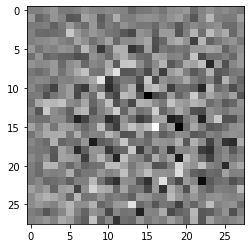

In [26]:
plt.imshow(imagem_gerada[0, :, :, 0], cmap='gray');

# Construção do discriminador

- Dropout: https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf
- Conv2d x Conv2dTranspose: https://stackoverflow.com/questions/68976745/in-keras-what-is-the-difference-between-conv2dtranspose-and-conv2d

## Define a arquitetura de uma rede discriminadora para uma GAN. 
Vamos analisar:

- Usa tf.keras.Sequential() para construir a rede como sequência de camadas.

- A primeira camada Conv2D recebe imagens 28x28x1 e as reduz para 14x14x64 filtros com um stride 2.

- layers.LeakyReLU e layers.Dropout adicionam não-linearidade e regularização. 

- A segunda camada Conv2D reduz o mapa de características novamente de 14x14 para 7x7x128.

- Outra camada LeakyReLU e Dropout seguem para regularização.

- layers.Flatten transforma os dados 7x7x128 em um array unidimensional.

- A última camada Dense tem um único neurônio com sigmoid para classificar as amostras entre 0 e 1.

Portanto, o discriminador reduz as imagens a mapas pequenos de características e then classifica em real ou fake. A saída vai para o gerador melhorar a geração.

In [27]:
def cria_discriminador():
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(filters = 64, strides=(2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(filters = 128, strides=(2,2), kernel_size = (5,5), padding = 'same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()

  return network

In [28]:
7 * 7 * 128

6272

In [29]:
discriminador = cria_discriminador()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [30]:
discriminador.input

<tf.Tensor 'conv2d_input:0' shape=(None, 28, 28, 1) dtype=float32>

In [31]:
discriminador(imagem_gerada, training = False) # logits

<tf.Tensor: id=779, shape=(1, 1), dtype=float32, numpy=array([[0.00206065]], dtype=float32)>

In [32]:
tf.sigmoid(0.00356018)

<tf.Tensor: id=781, shape=(), dtype=float32, numpy=0.5008901>

# Cálculo do erro

- Logits: https://deepai.org/machine-learning-glossary-and-terms/logit

Este método quantifica quão bem o discriminador é capaz de distinguir imagens reais de falsificações. Ele compara as previsões do discriminador em imagens reais com uma matriz de 1s e as previsões do discriminador em imagens falsas (geradas) com uma matriz de 0s.

In [33]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [34]:
tf.ones_like(1)

<tf.Tensor: id=785, shape=(), dtype=int32, numpy=1>

In [35]:
tf.zeros_like(1)

<tf.Tensor: id=787, shape=(), dtype=int32, numpy=0>

In [36]:
def discriminador_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [37]:
def gerador_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [38]:
gerador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
discriminador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Treinamento da GAN e visualização dos resultados

- Adaptado de: https://www.tensorflow.org/beta/tutorials/generative/dcgan
- @tf.function: https://www.tensorflow.org/guide/function#:~:text=You%20can%20use%20tf.,is%20required%20to%20use%20SavedModel%20.

In [39]:
X_treinamento

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [40]:
epocas = 100
dimensao_ruido = 100
numero_imagens = 16

In [41]:
batch_size, dimensao_ruido

(256, 100)

In [42]:
@tf.function
def treinamento(imagens):
  ruido = tf.random.normal([batch_size, dimensao_ruido])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    imagens_geradas = gerador(ruido, training = True)

    expected_output = discriminador(imagens, training = True)
    fake_output = discriminador(imagens_geradas, training = True)

    gen_loss = gerador_loss(fake_output)
    disc_loss = discriminador_loss(expected_output, fake_output)

  gradientes_gerador = gen_tape.gradient(gen_loss, gerador.trainable_variables)
  gradientes_discriminador = disc_tape.gradient(disc_loss, discriminador.trainable_variables)

  gerador_optimizer.apply_gradients(zip(gradientes_gerador, gerador.trainable_variables))
  discriminador_optimizer.apply_gradients(zip(gradientes_discriminador, discriminador.trainable_variables))

In [43]:
imagens_teste = tf.random.normal([numero_imagens, dimensao_ruido])
imagens_teste.shape

TensorShape([16, 100])

In [44]:
60000 / 256

234.375

In [45]:
def treina_gan(dataset, epocas, imagens_teste):
  for epoca in range(epocas):
    for imagem_batch in dataset:
      #print(imagem_batch.shape)
      treinamento(imagem_batch)

    print('Época: ', epoca + 1)
    imagens_geradas = gerador(imagens_teste, training=False)
    fig = plt.figure(figsize = (10,10))
    for i in range(imagens_geradas.shape[0]):
      plt.subplot(4,4,i+1)
      plt.imshow(imagens_geradas[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
      plt.axis('off')
    plt.show()

Época:  1


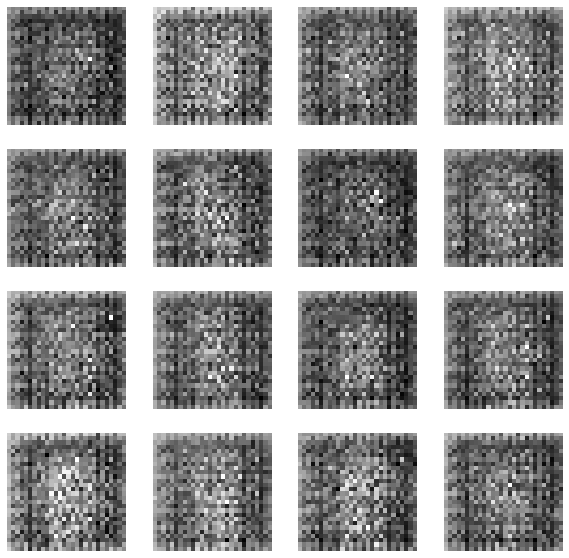

Época:  2


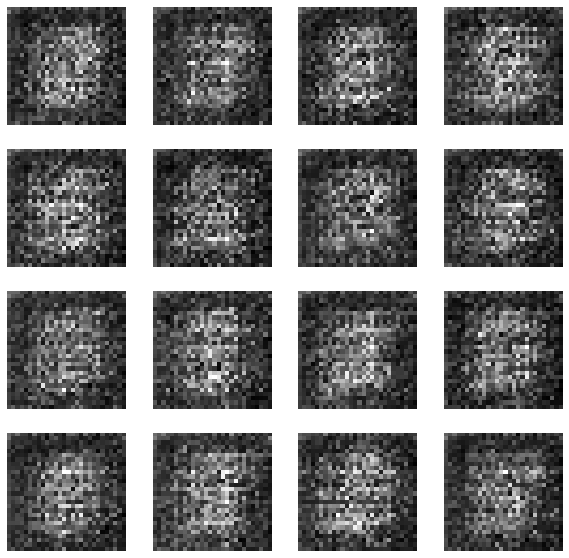

Época:  3


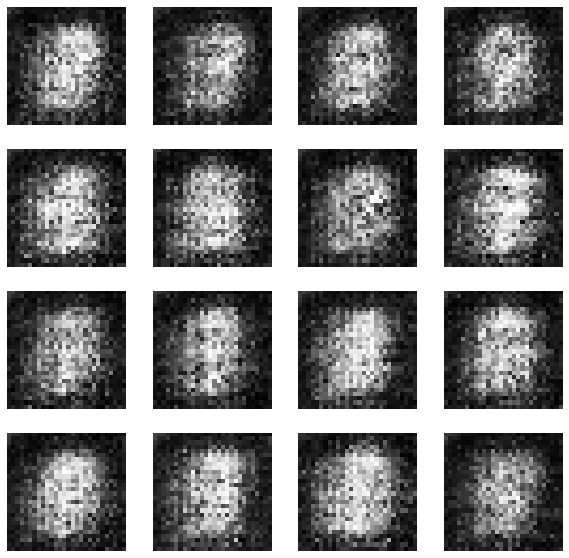

Época:  4


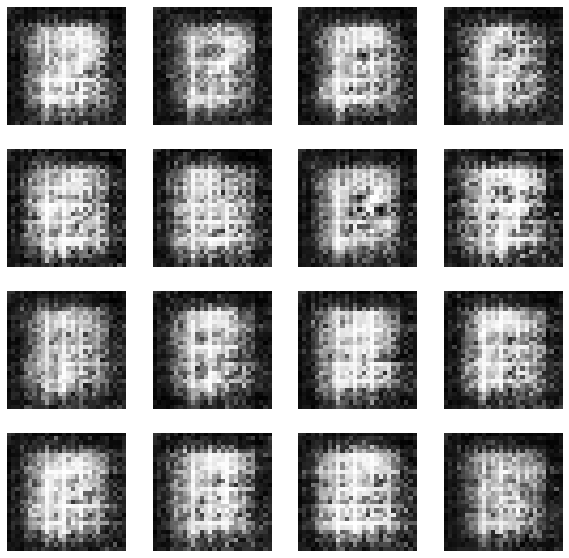

Época:  5


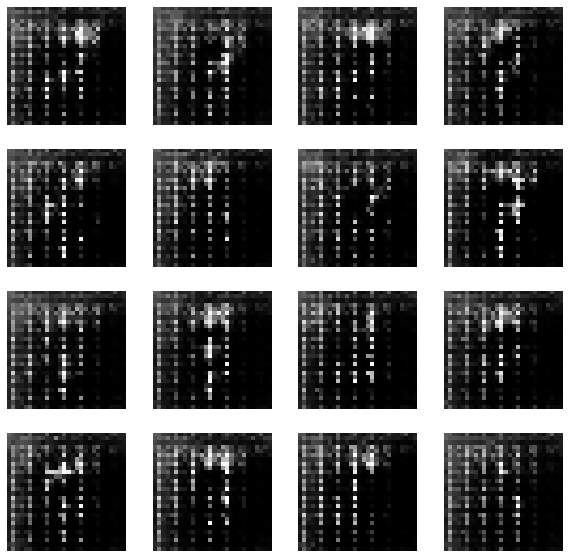

Época:  6


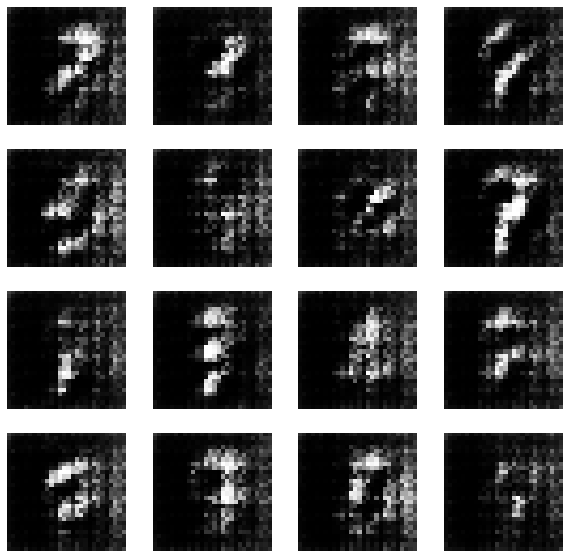

Época:  7


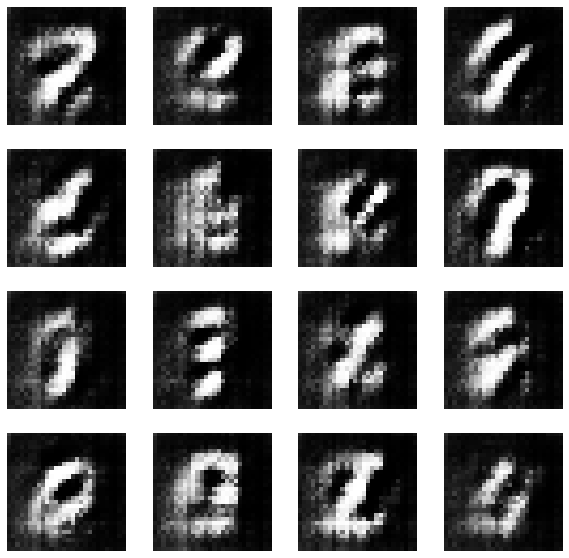

Época:  8


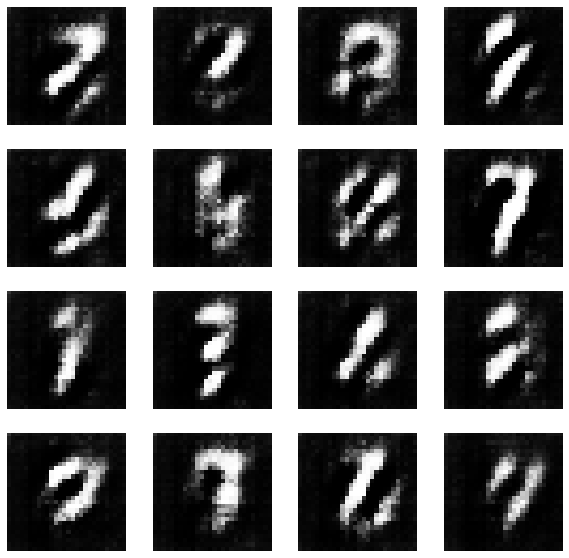

Época:  9


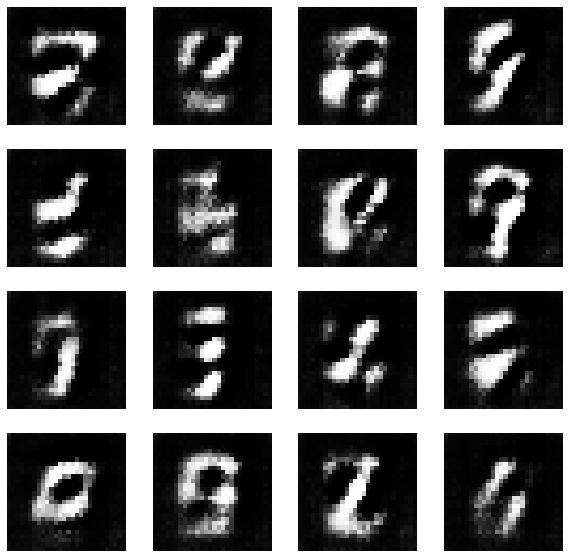

Época:  10


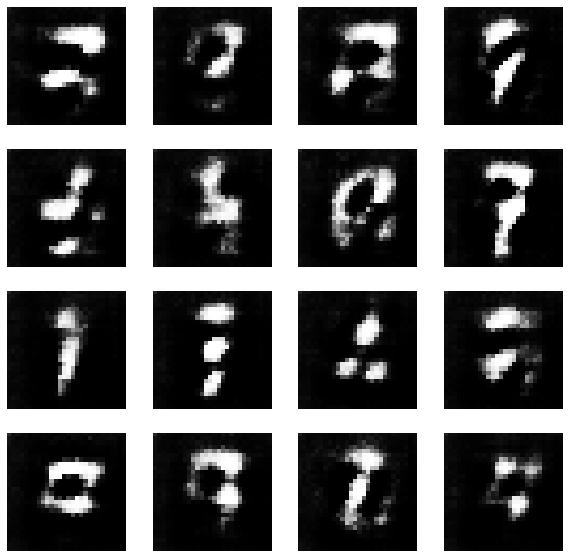

Época:  11


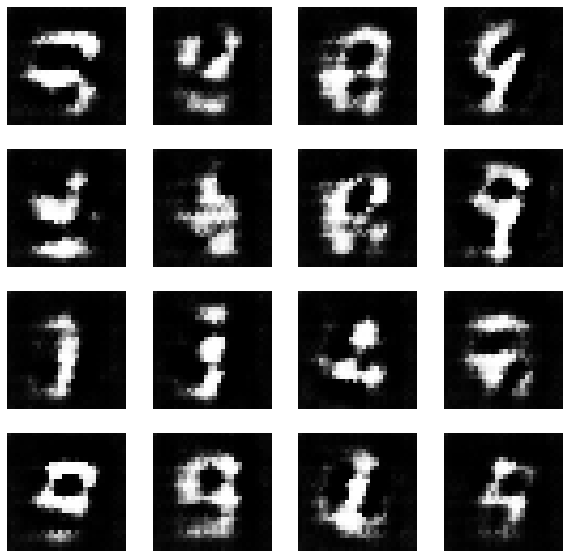

Época:  12


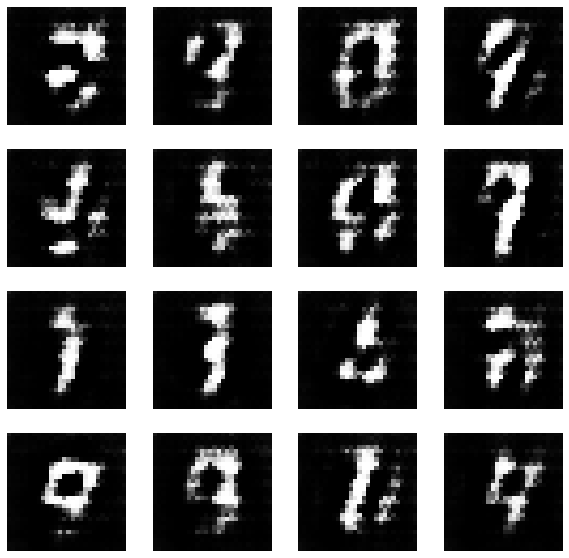

Época:  13


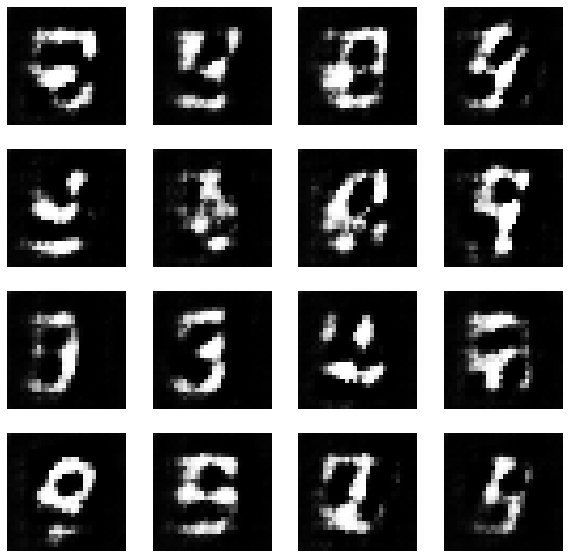

Época:  14


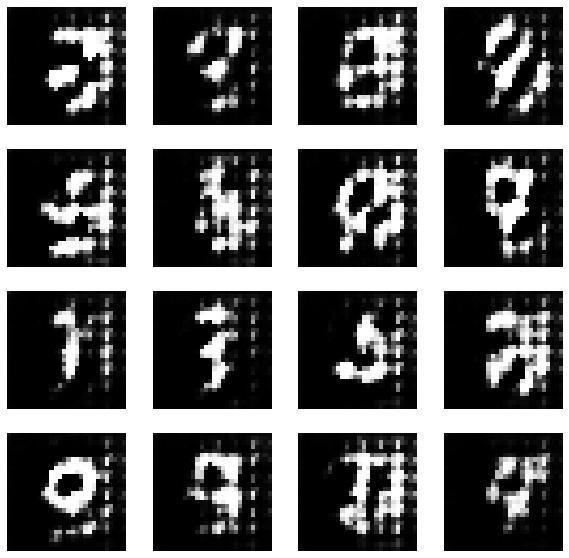

Época:  15


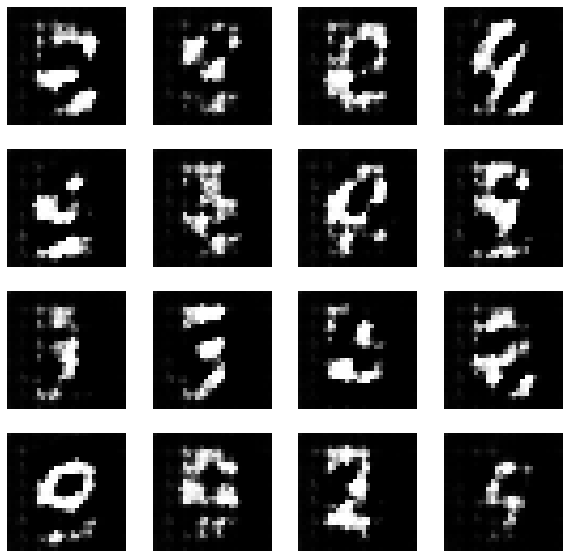

Época:  16


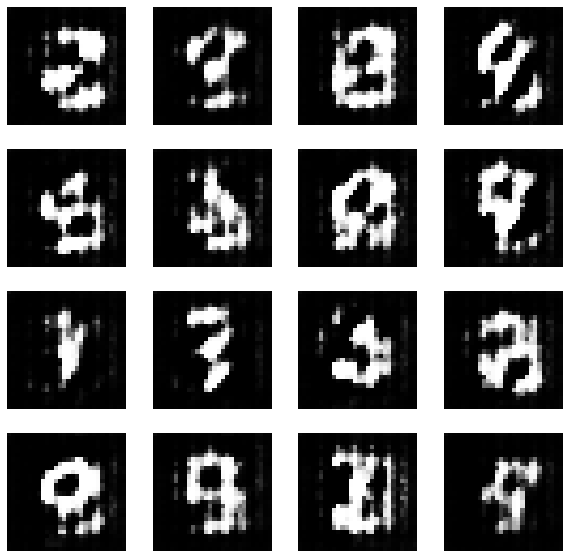

Época:  17


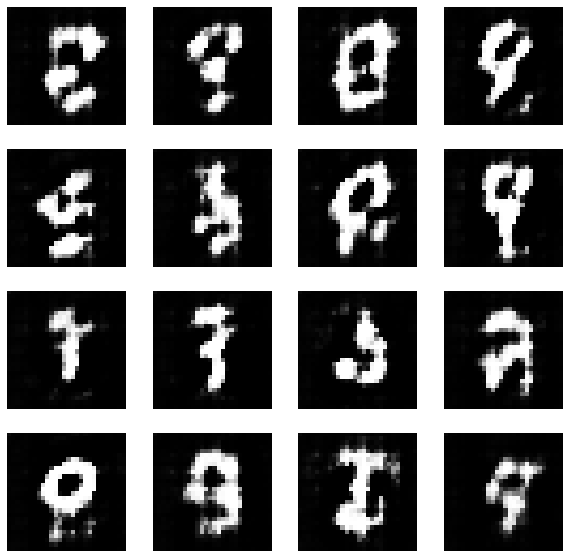

Época:  18


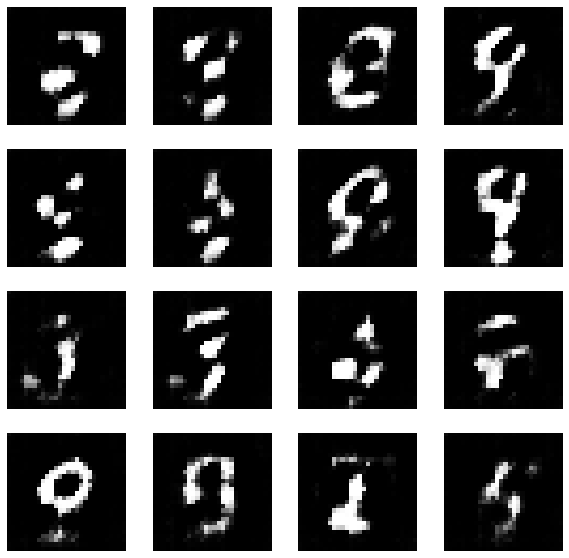

Época:  19


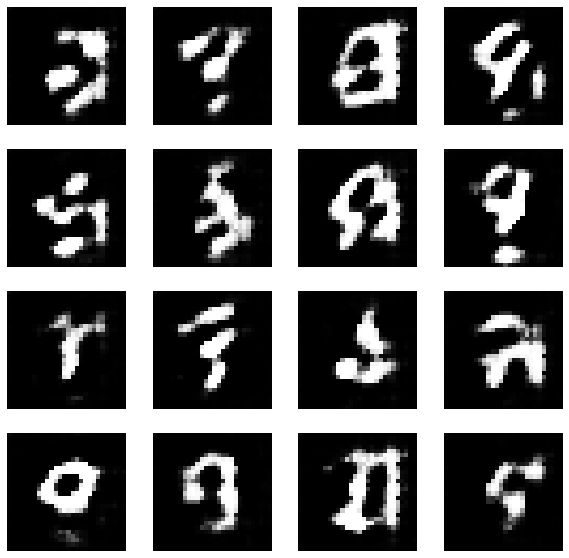

Época:  20


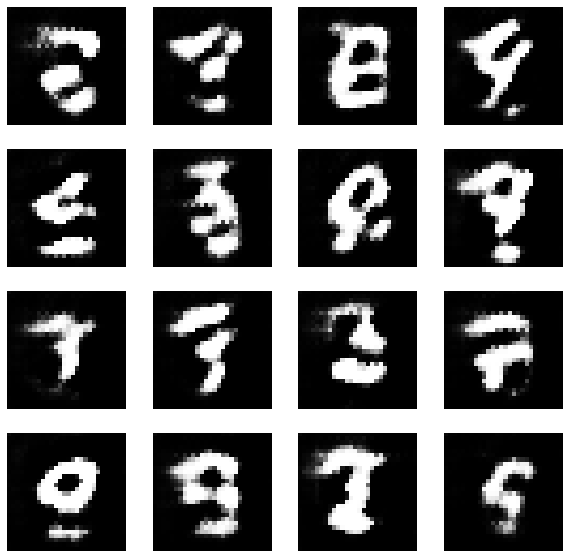

Época:  21


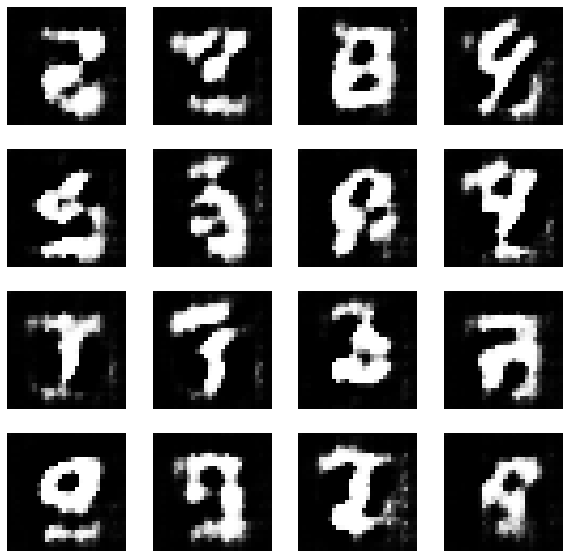

Época:  22


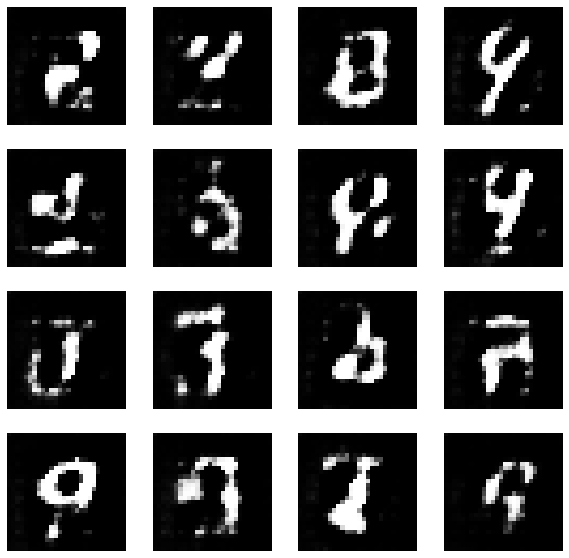

Época:  23


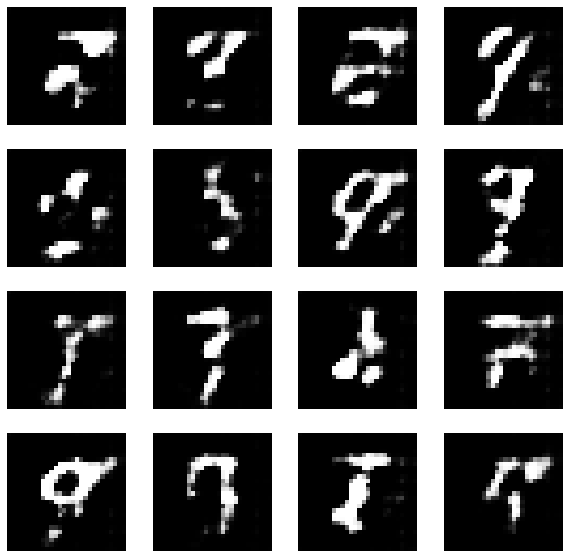

Época:  24


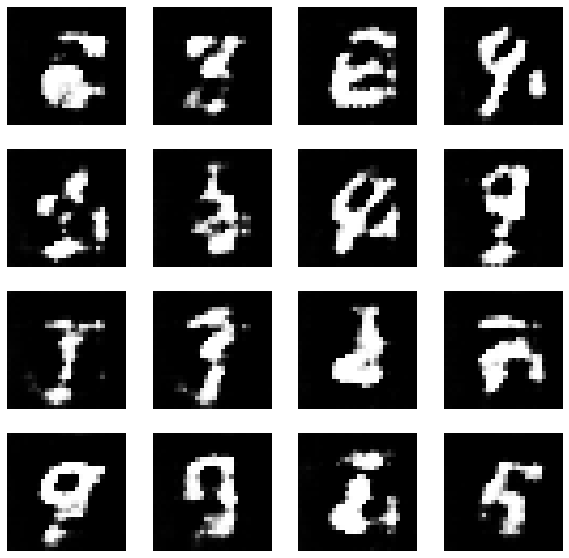

Época:  25


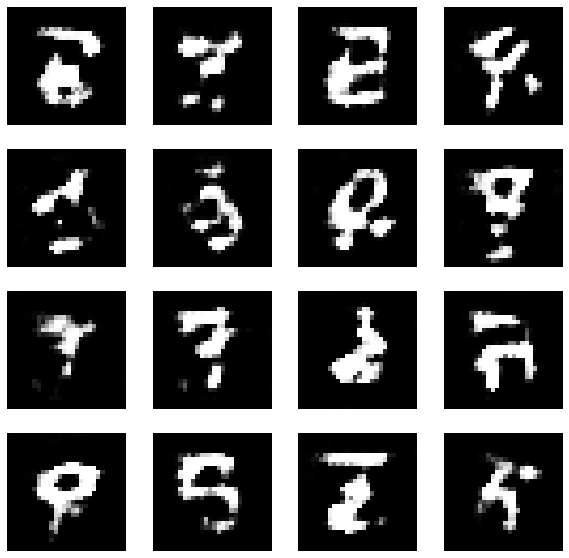

Época:  26


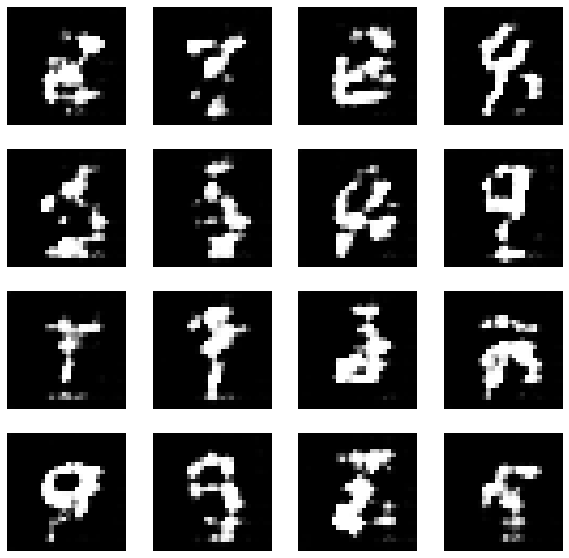

Época:  27


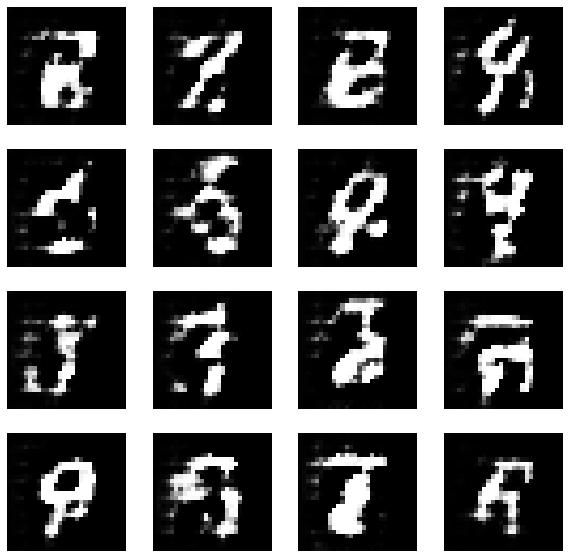

Época:  28


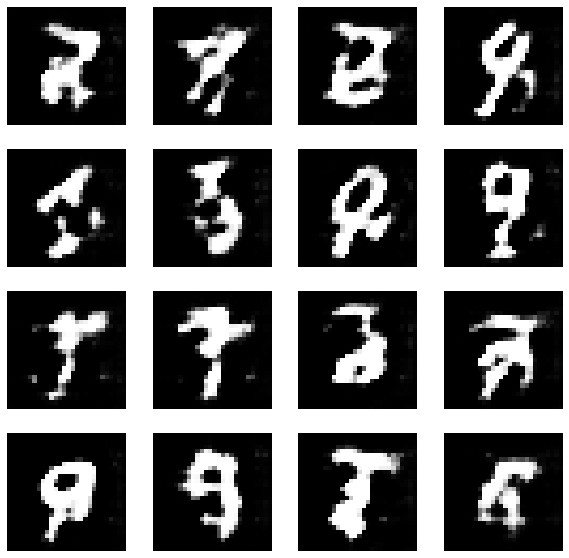

Época:  29


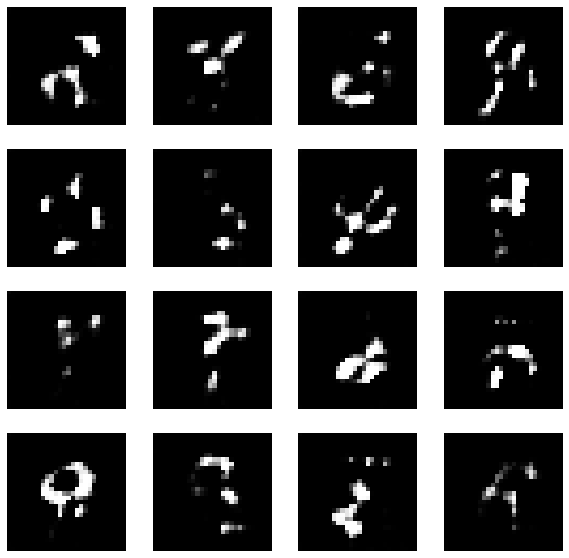

Época:  30


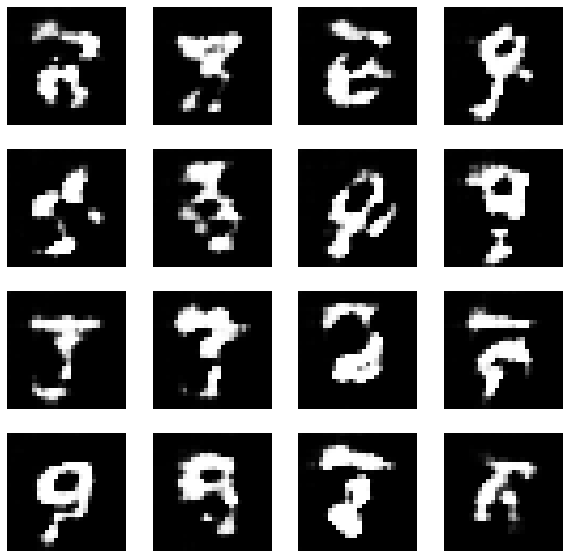

Época:  31


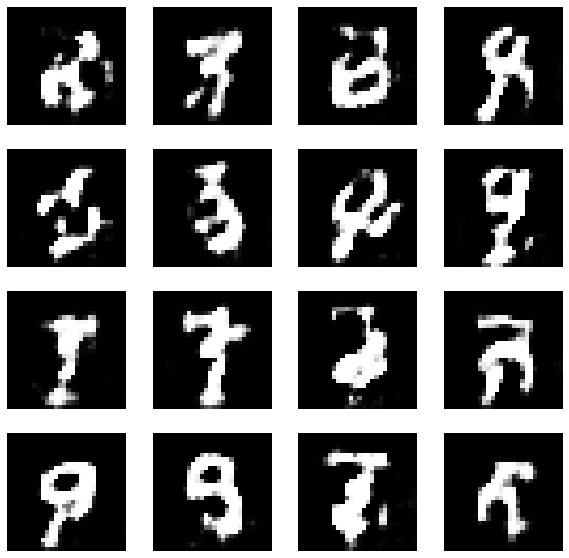

Época:  32


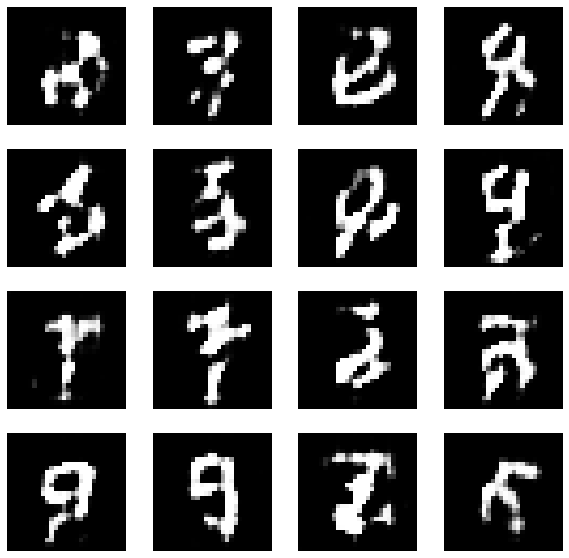

Época:  33


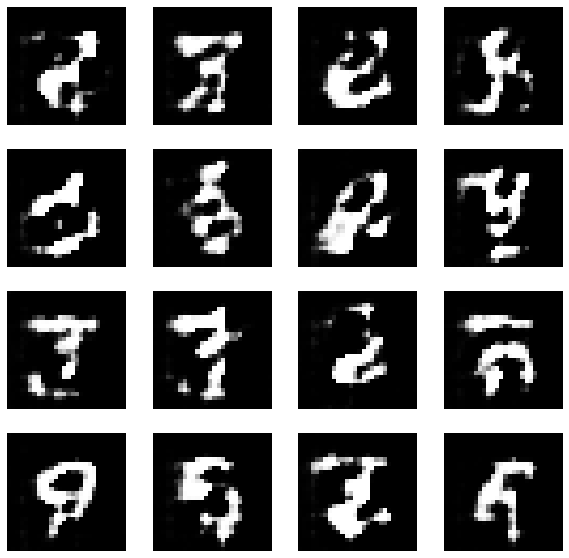

Época:  34


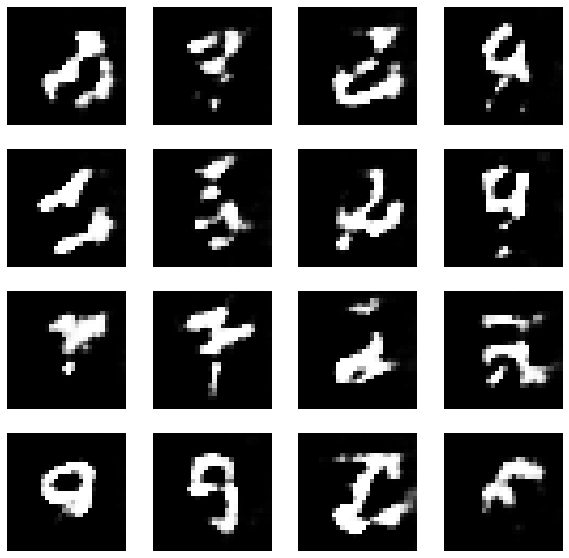

Época:  35


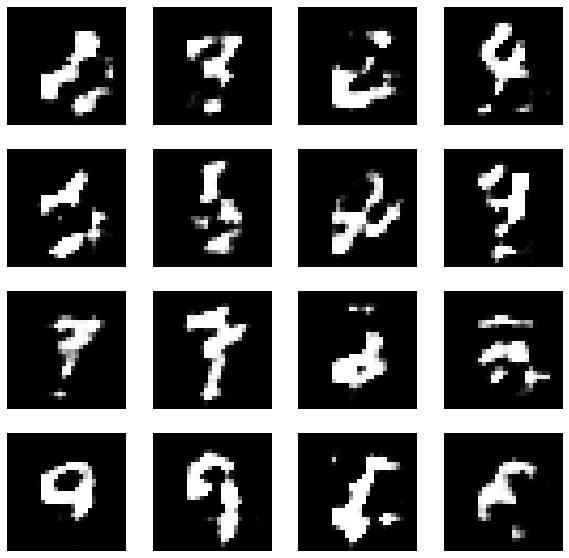

Época:  36


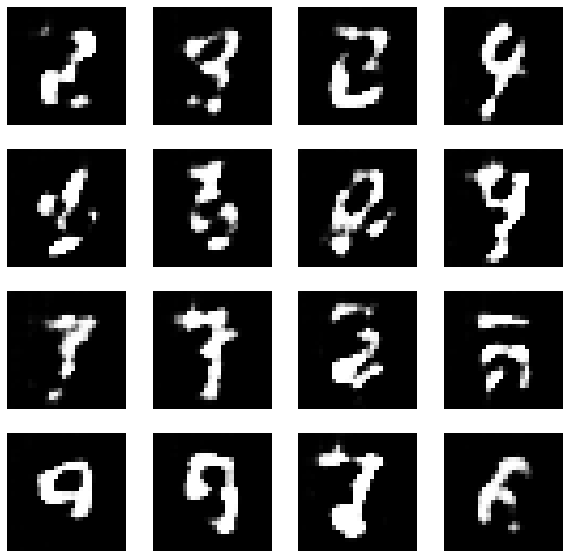

Época:  37


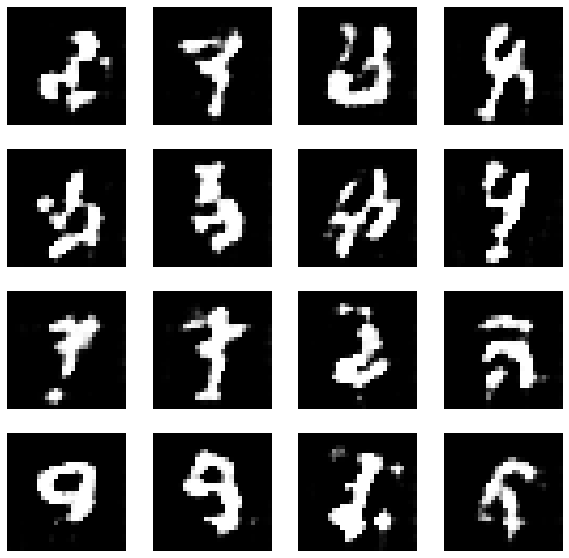

Época:  38


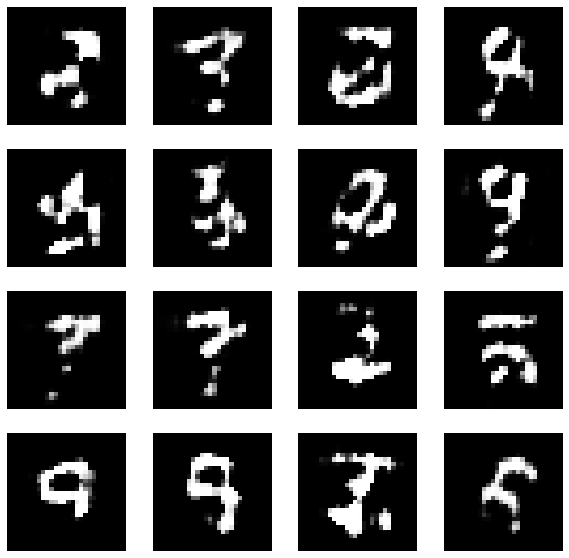

Época:  39


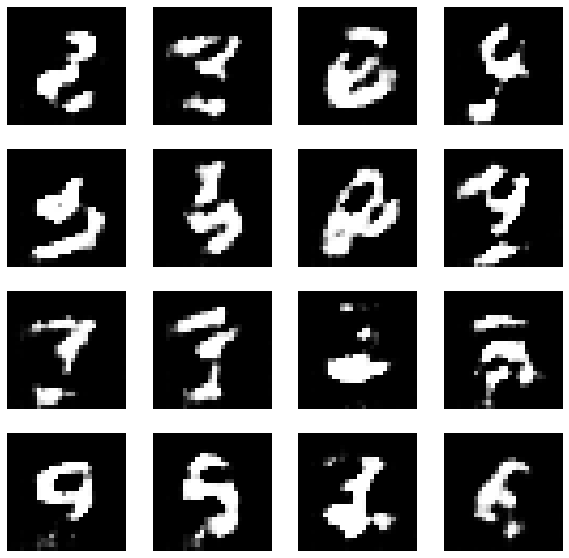

Época:  40


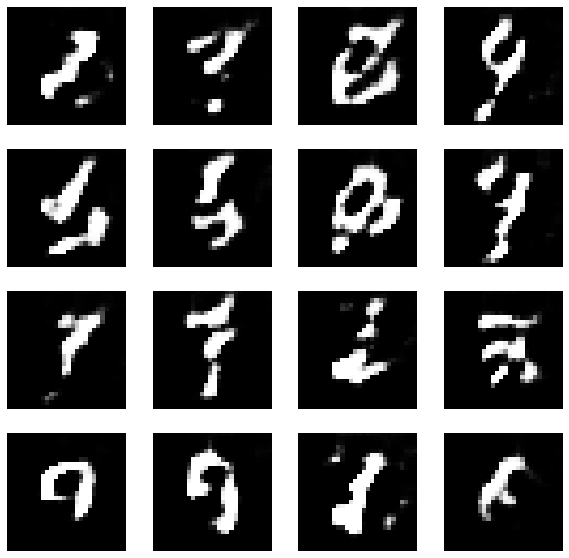

Época:  41


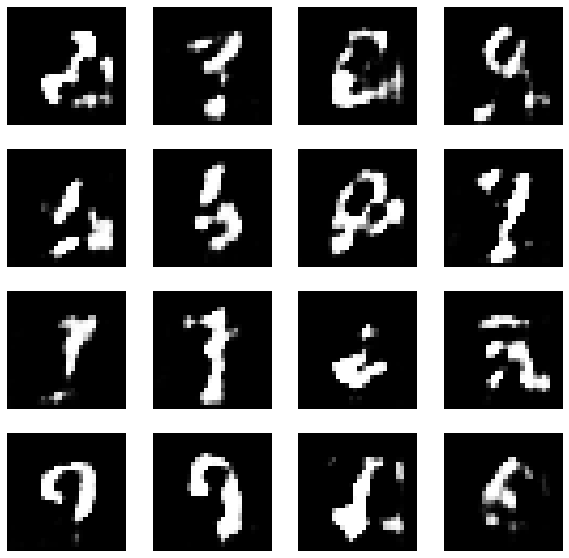

Época:  42


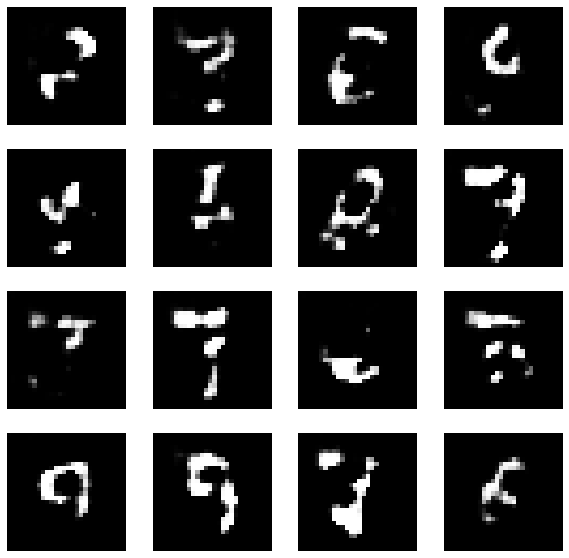

Época:  43


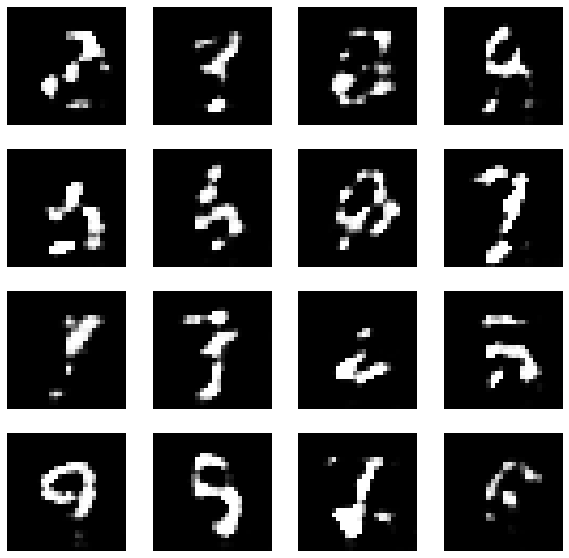

Época:  44


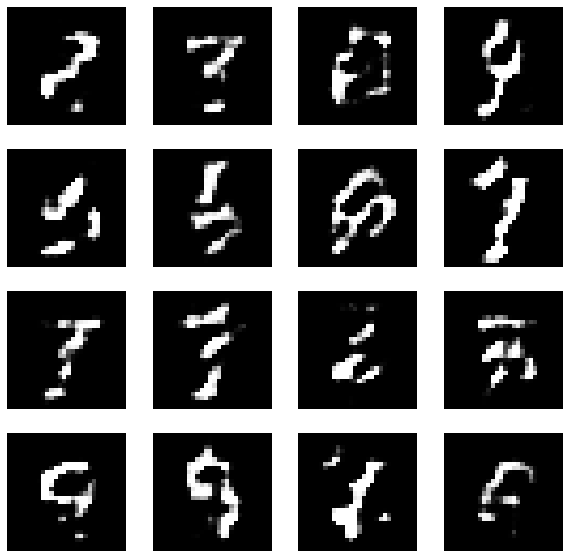

Época:  45


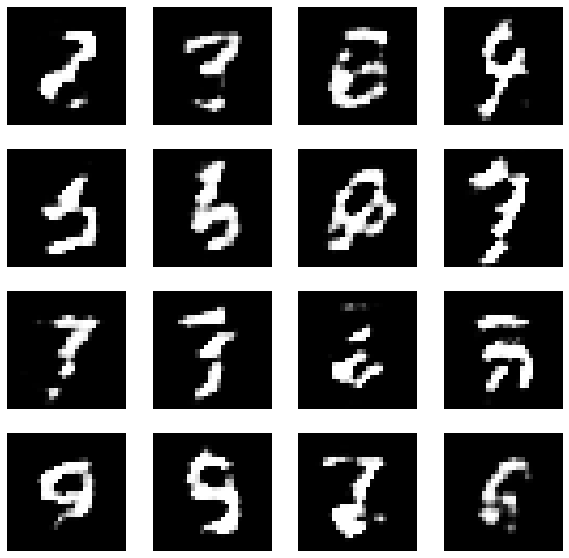

Época:  46


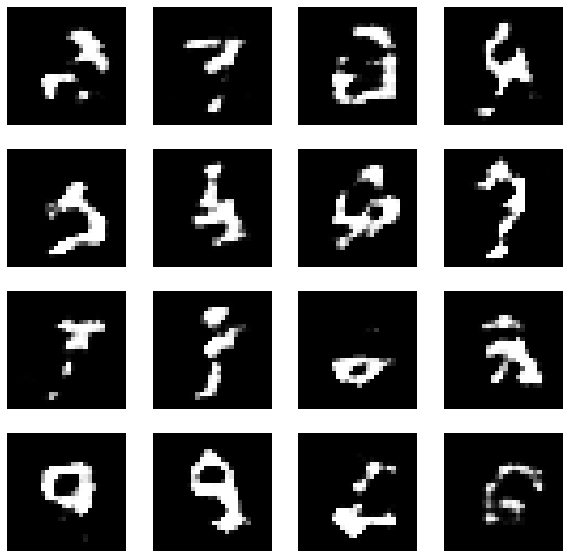

Época:  47


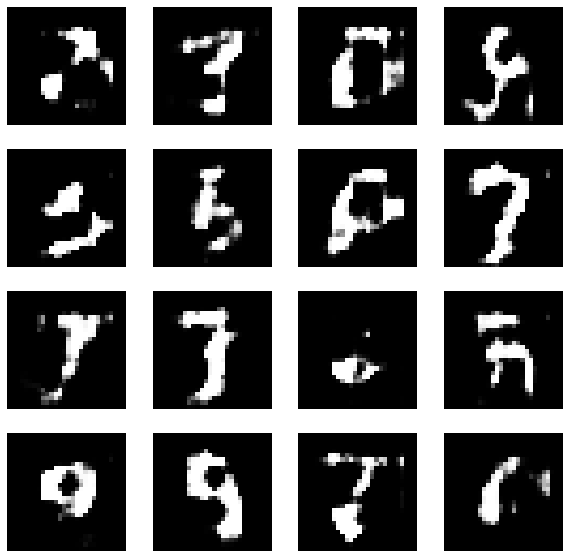

Época:  48


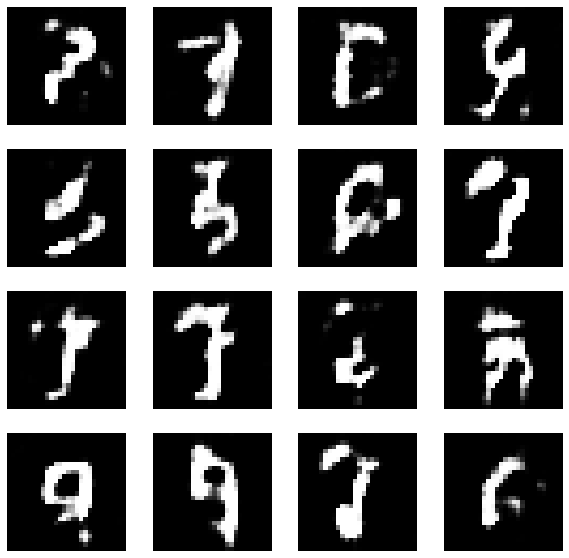

Época:  49


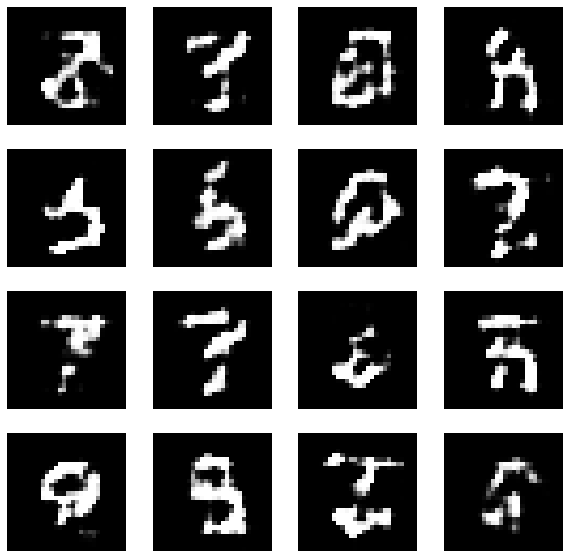

Época:  50


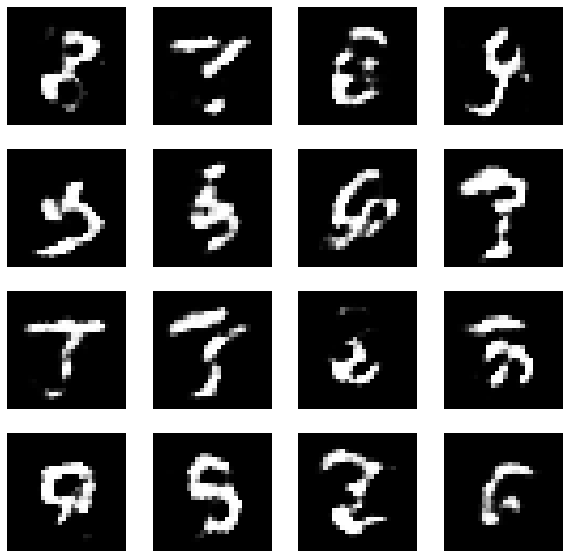

Época:  51


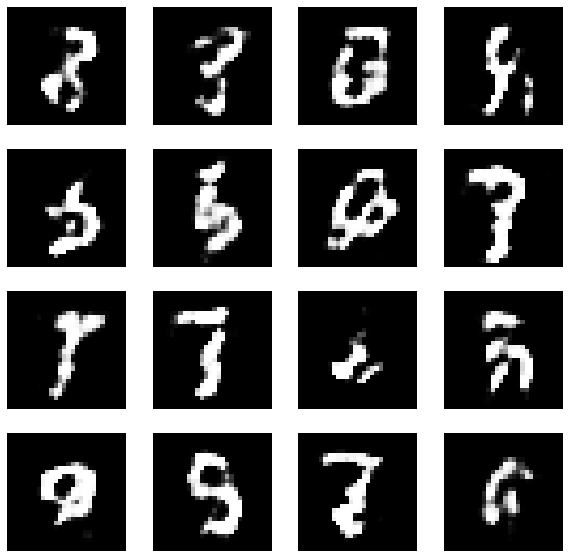

Época:  52


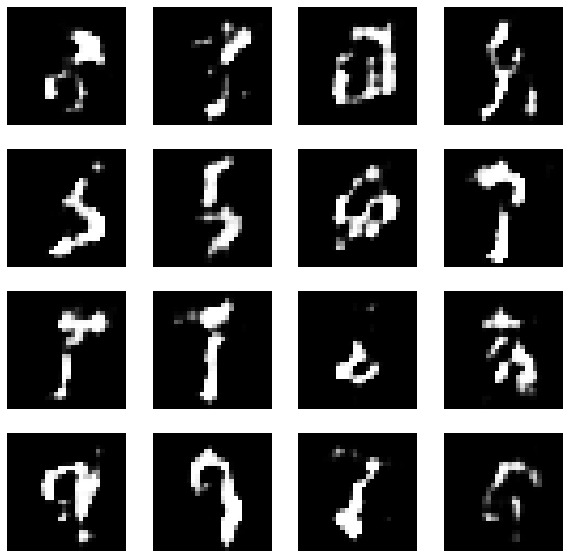

Época:  53


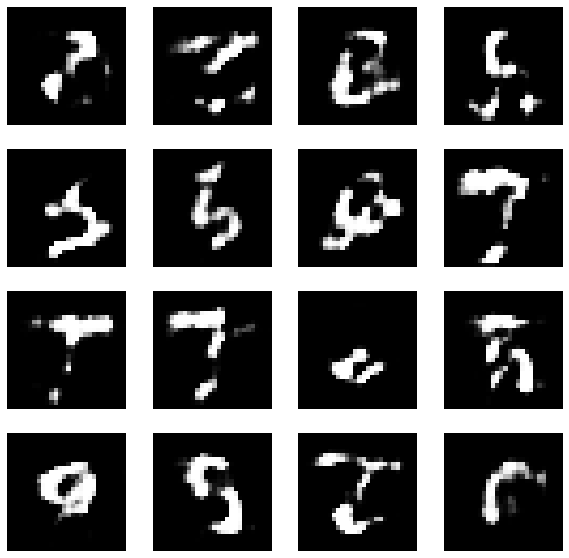

Época:  54


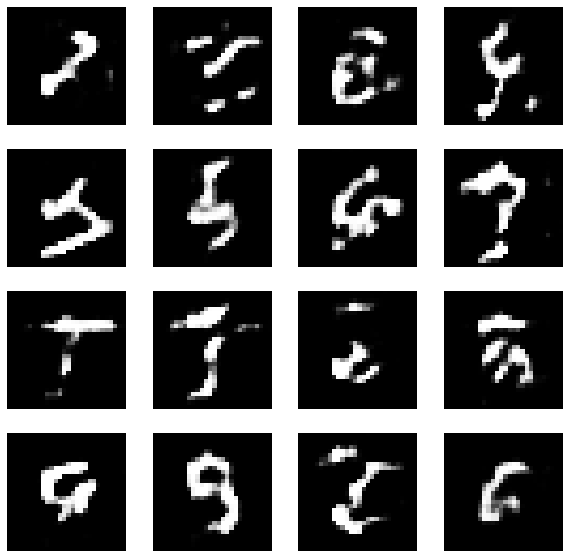

Época:  55


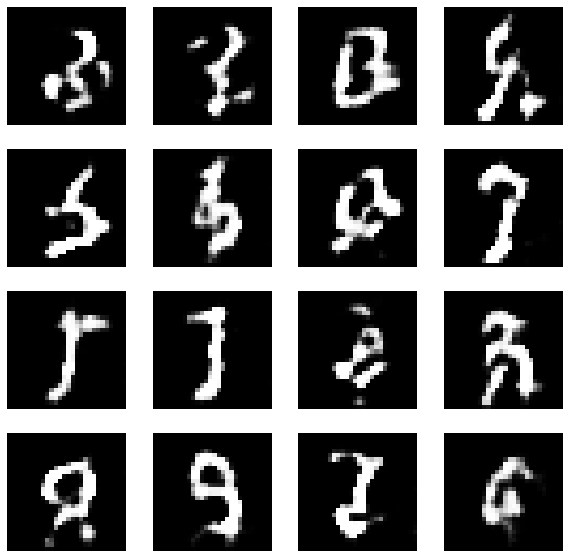

Época:  56


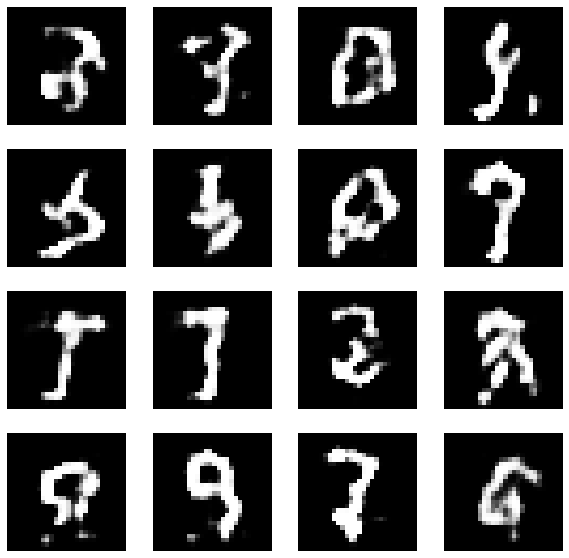

Época:  57


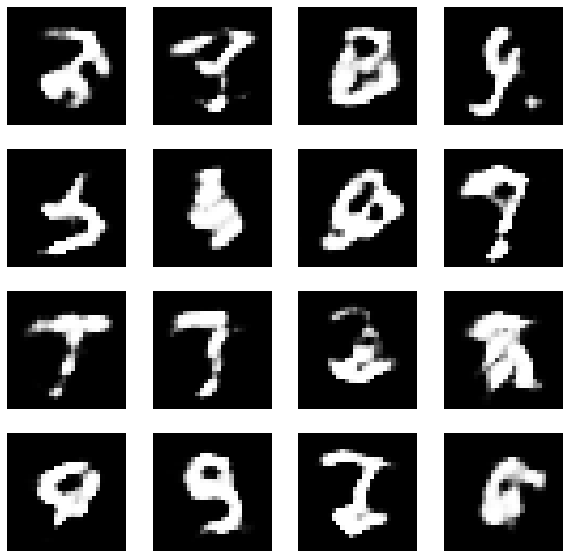

Época:  58


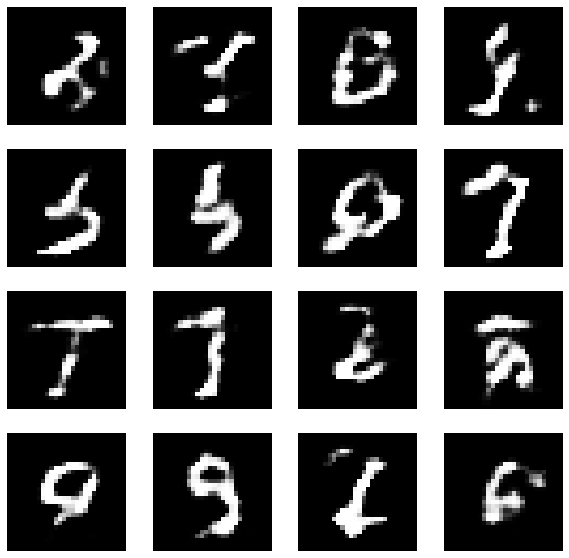

Época:  59


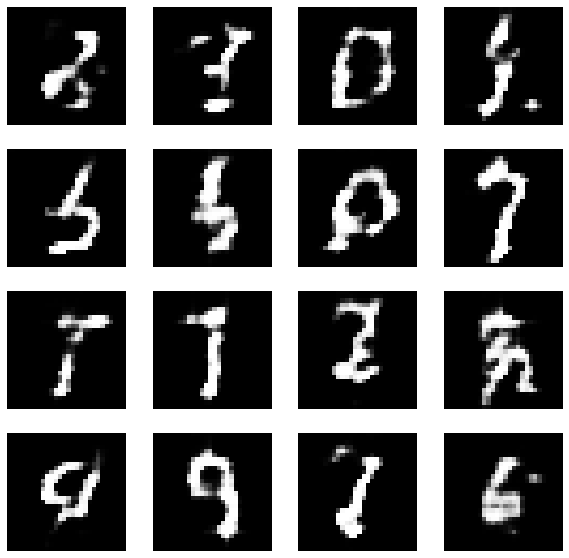

Época:  60


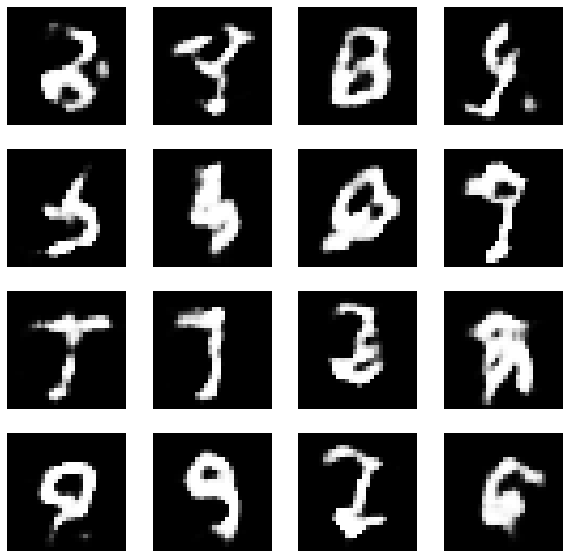

Época:  61


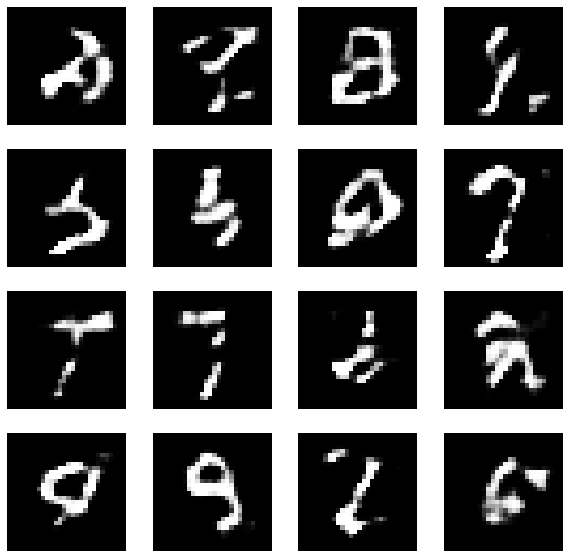

Época:  62


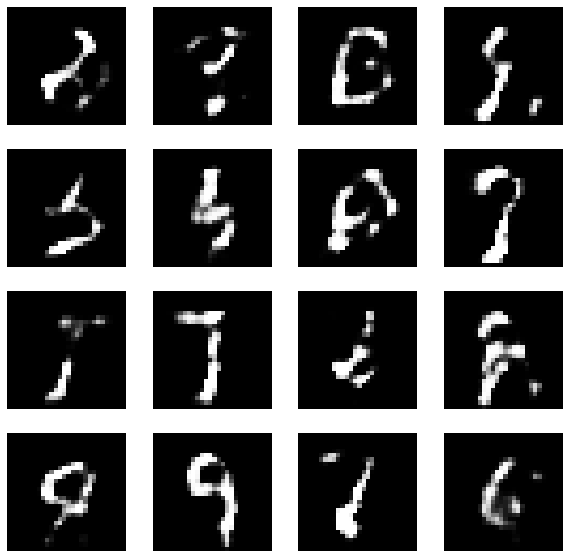

Época:  63


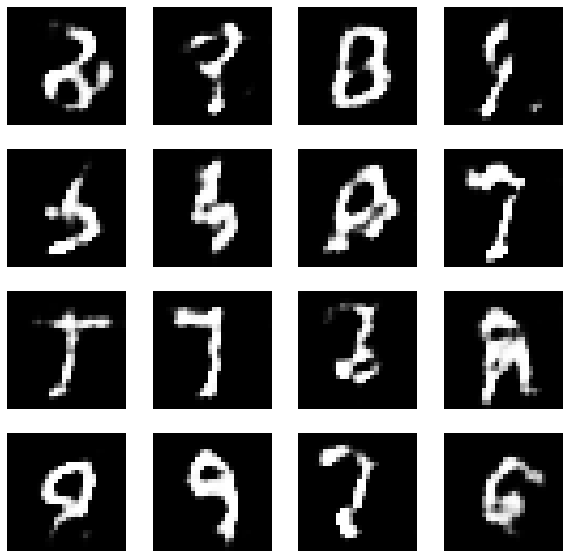

Época:  64


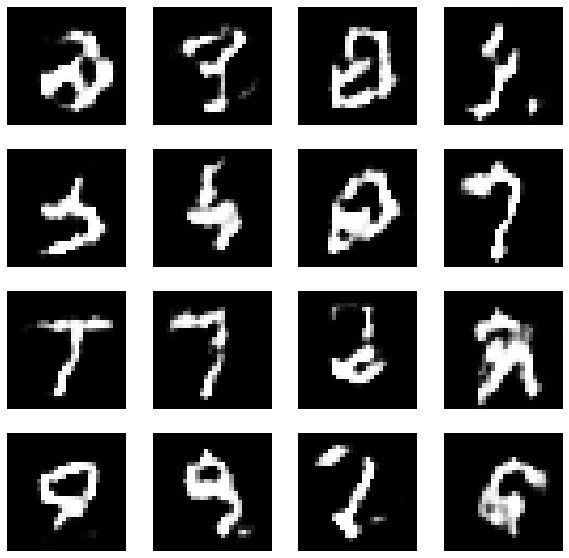

Época:  65


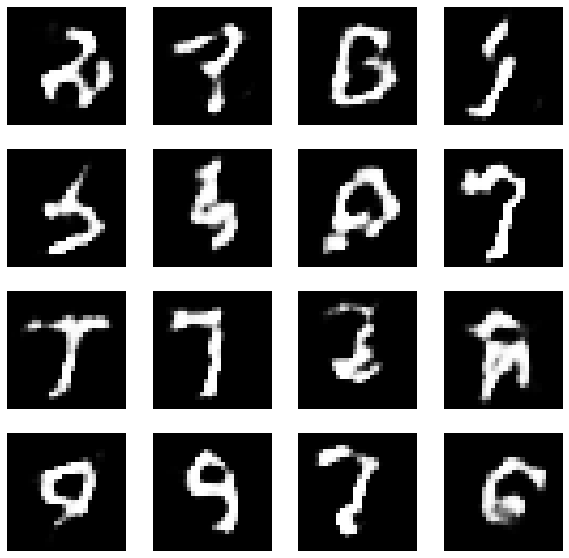

Época:  66


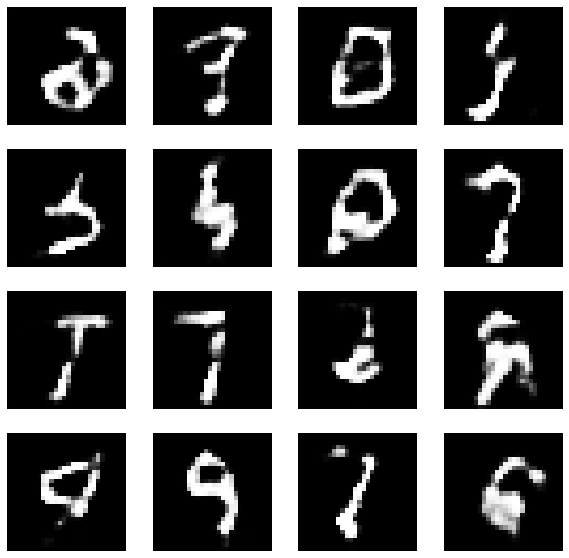

Época:  67


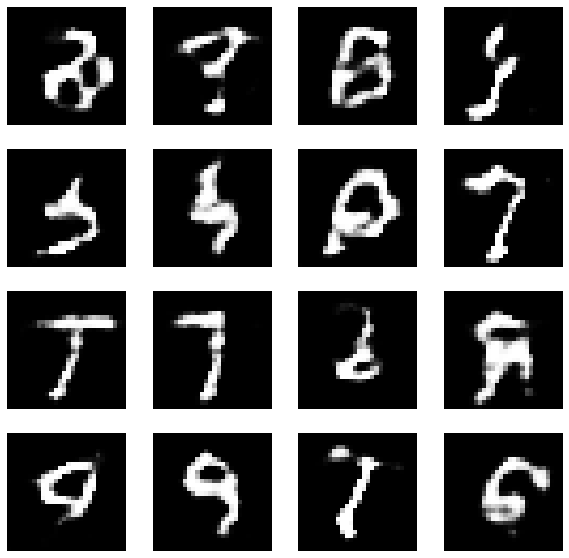

Época:  68


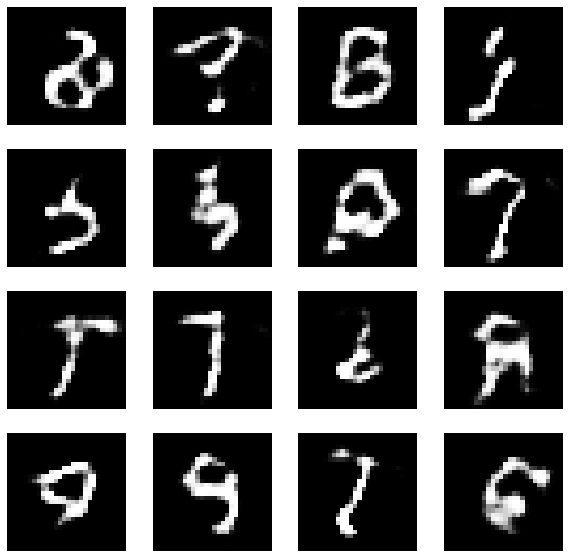

Época:  69


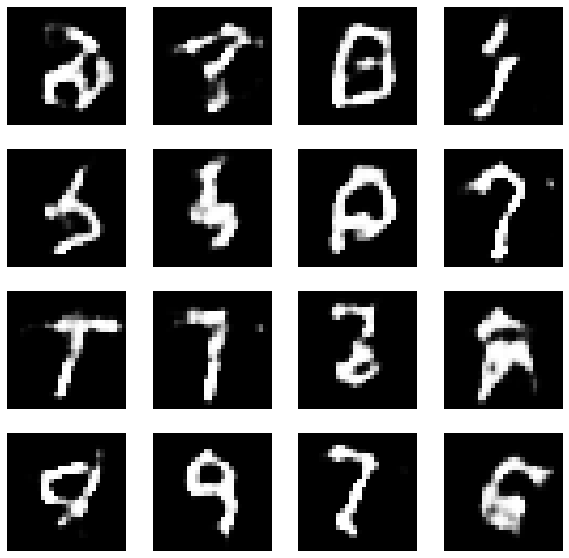

Época:  70


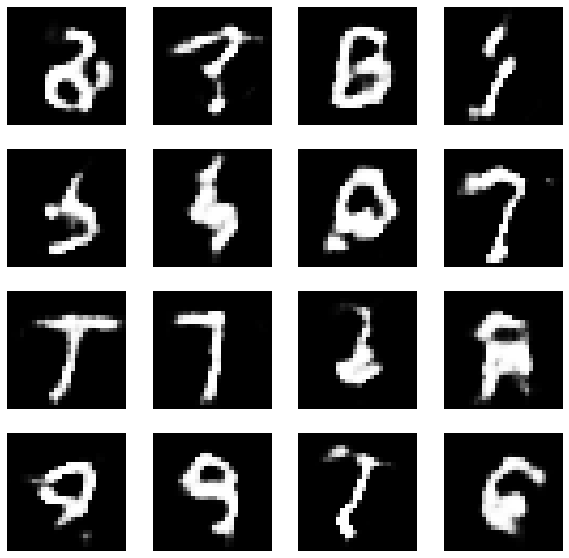

Época:  71


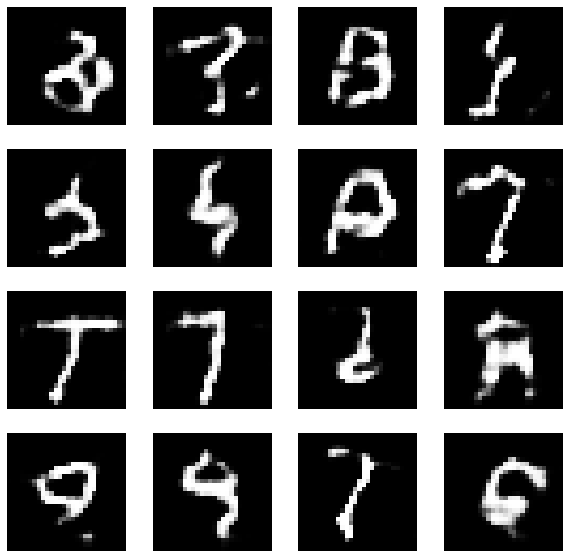

Época:  72


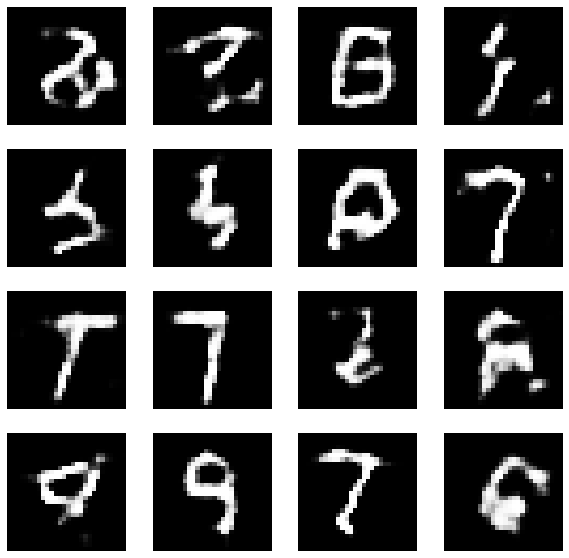

Época:  73


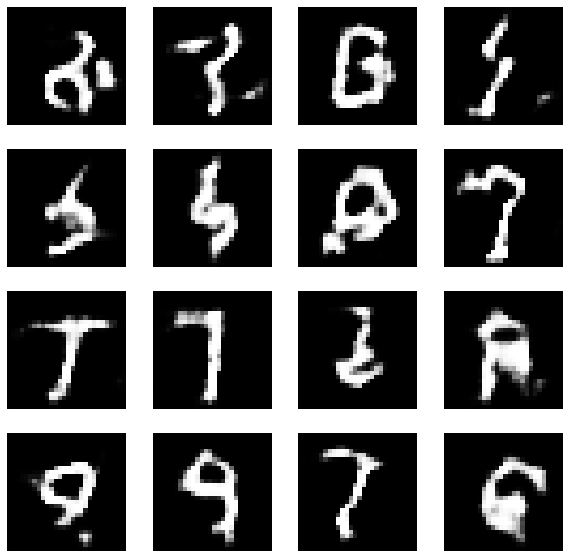

Época:  74


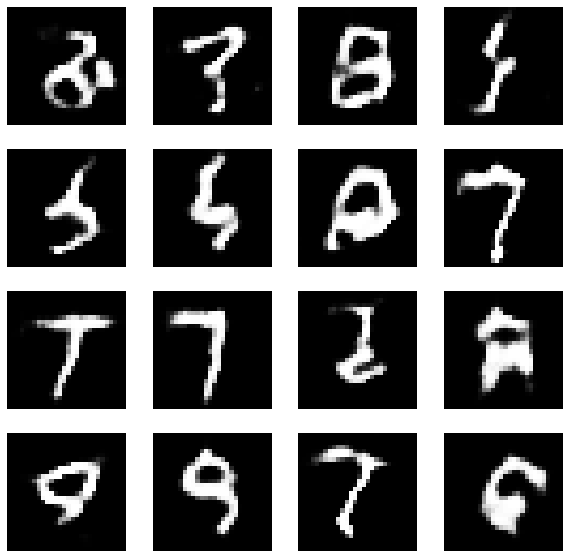

Época:  75


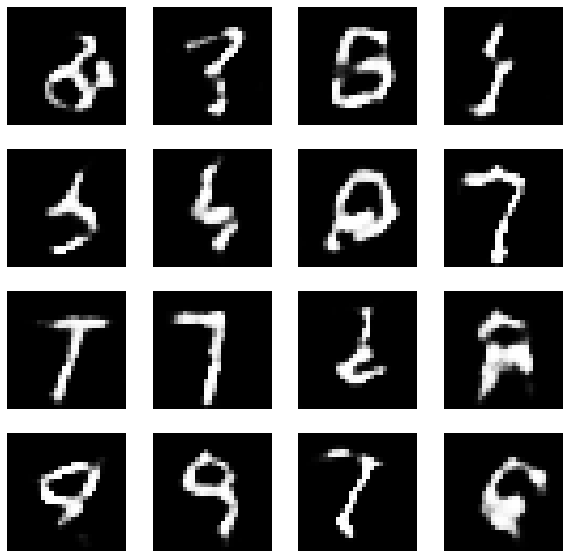

Época:  76


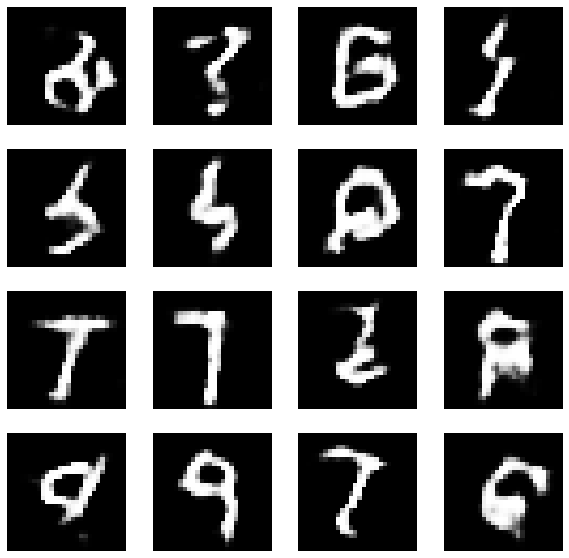

Época:  77


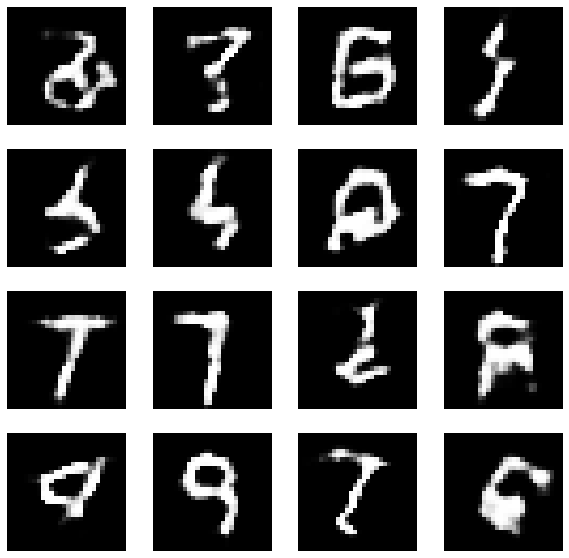

Época:  78


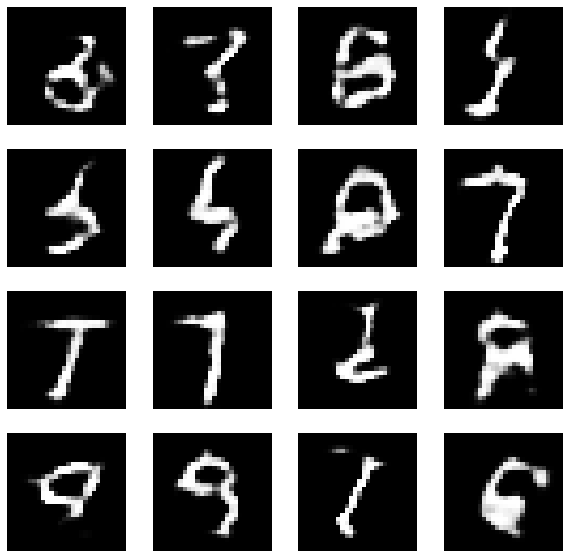

Época:  79


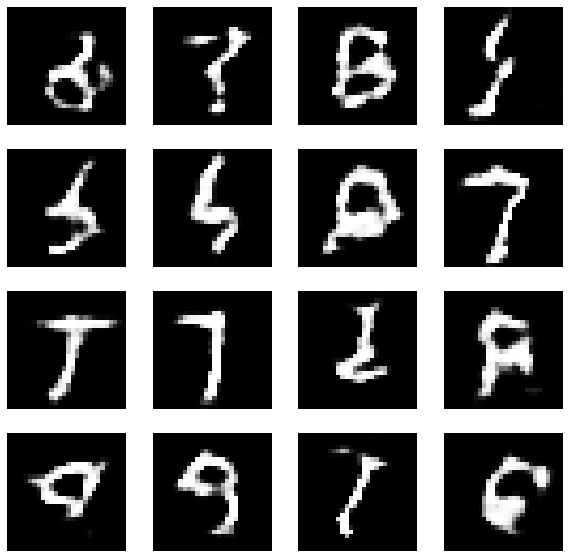

Época:  80


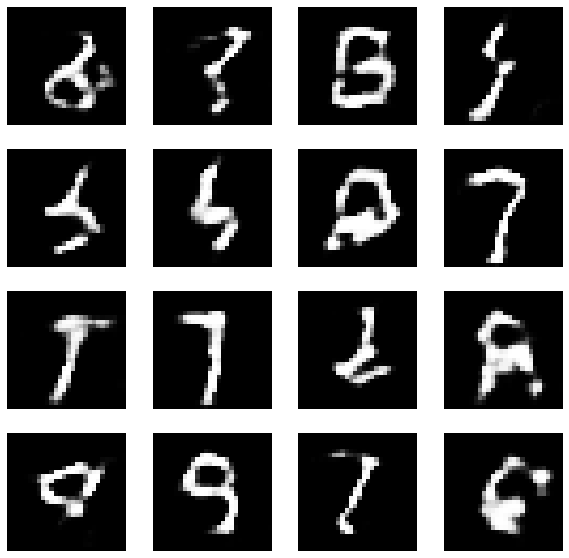

Época:  81


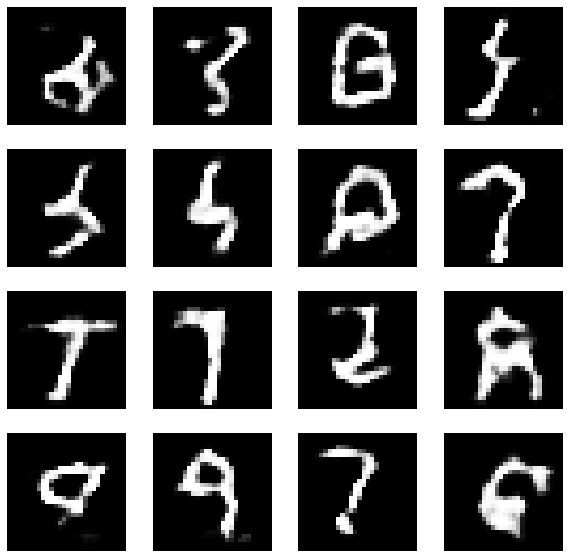

Época:  82


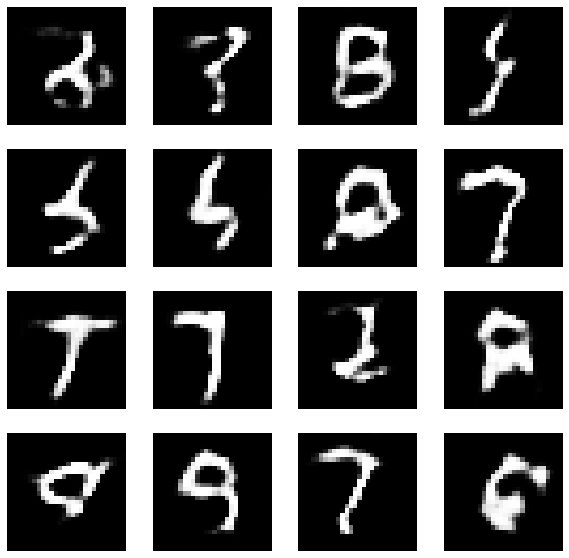

Época:  83


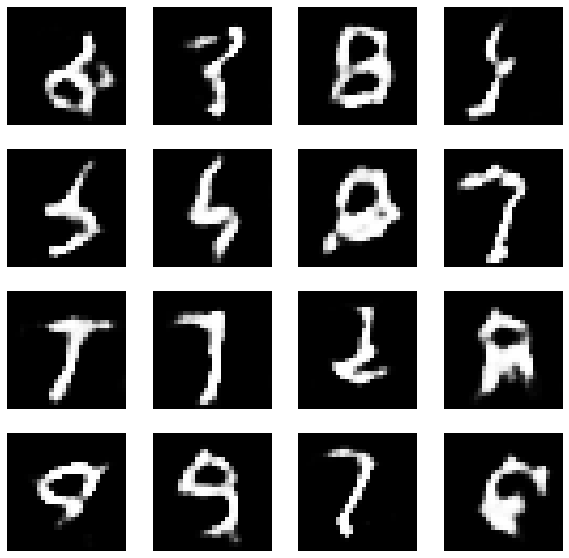

Época:  84


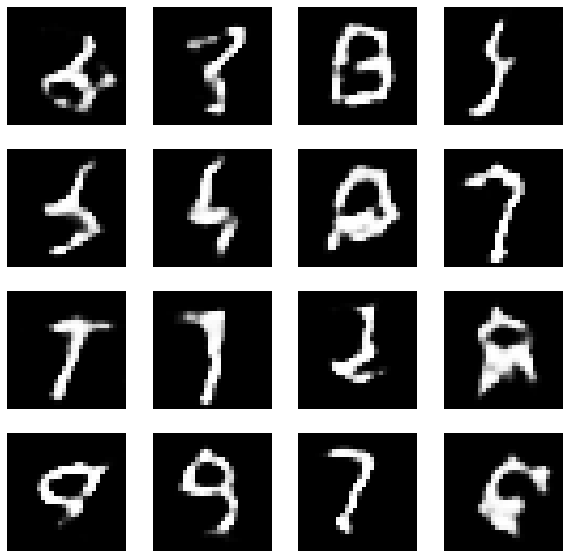

Época:  85


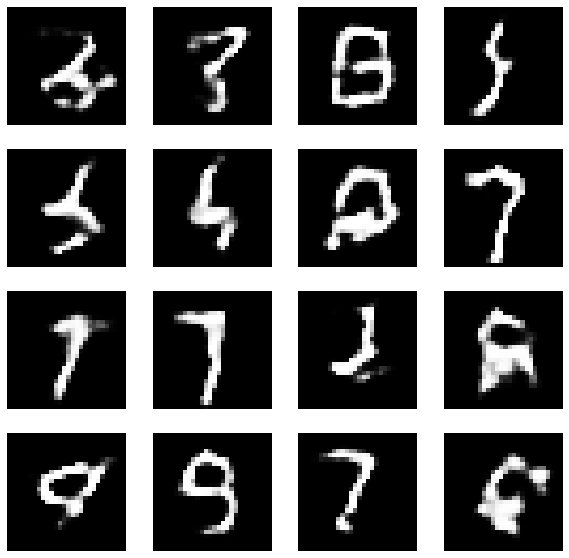

Época:  86


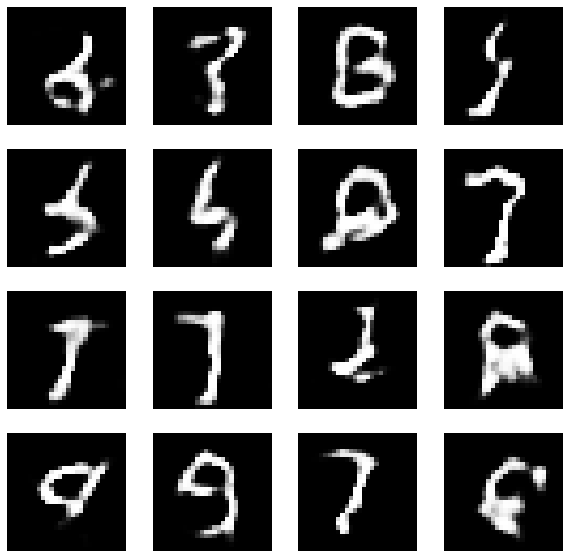

Época:  87


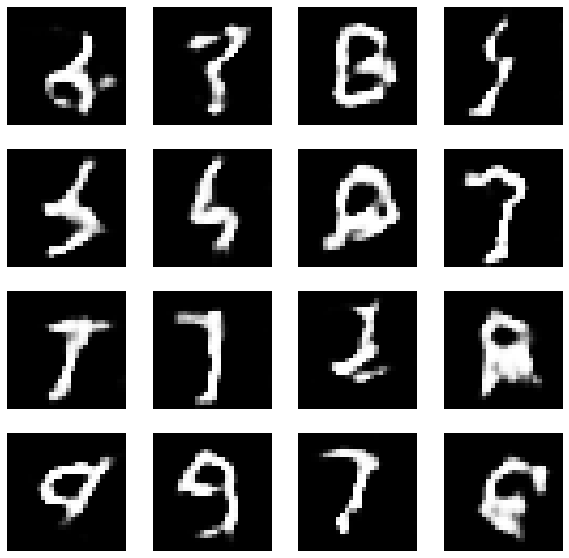

Época:  88


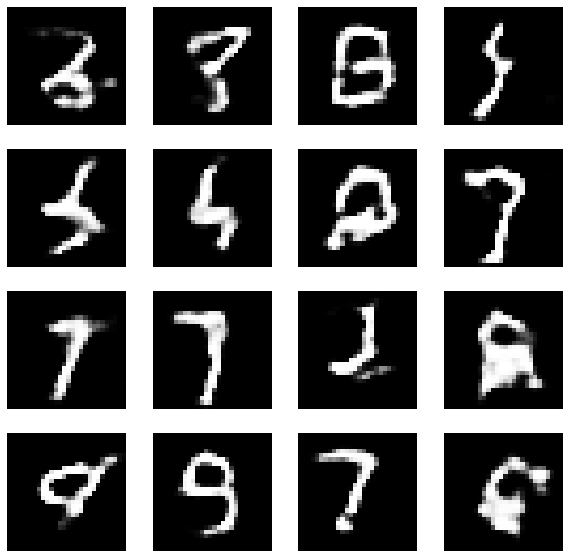

Época:  89


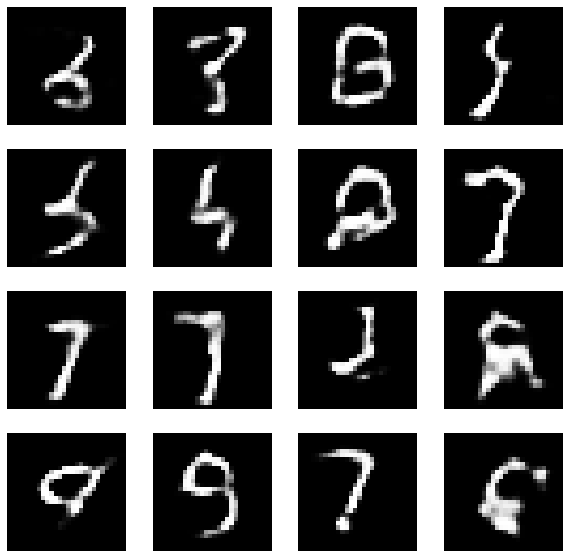

Época:  90


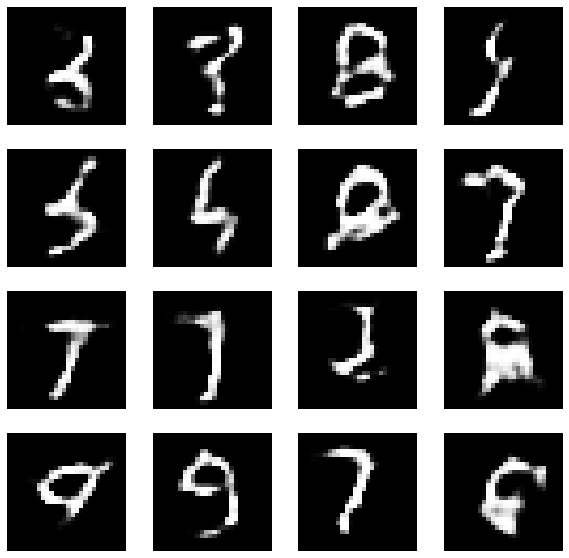

Época:  91


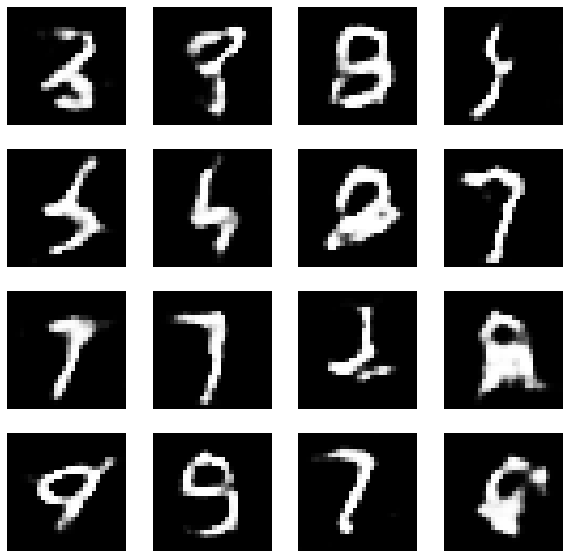

Época:  92


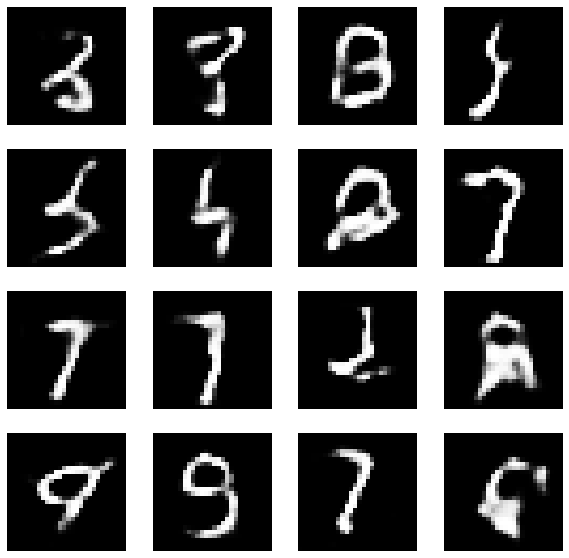

Época:  93


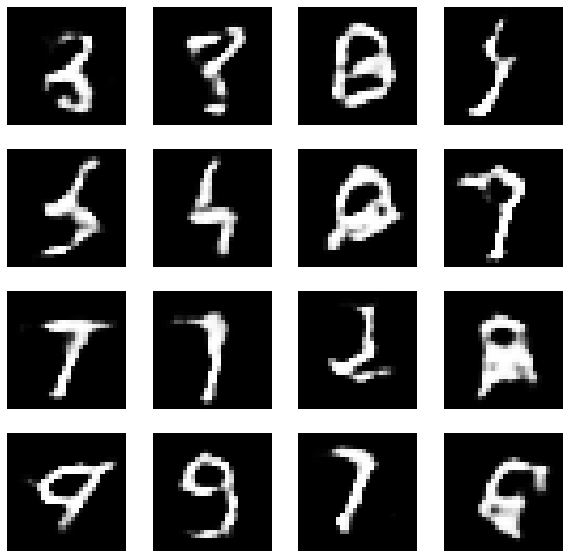

Época:  94


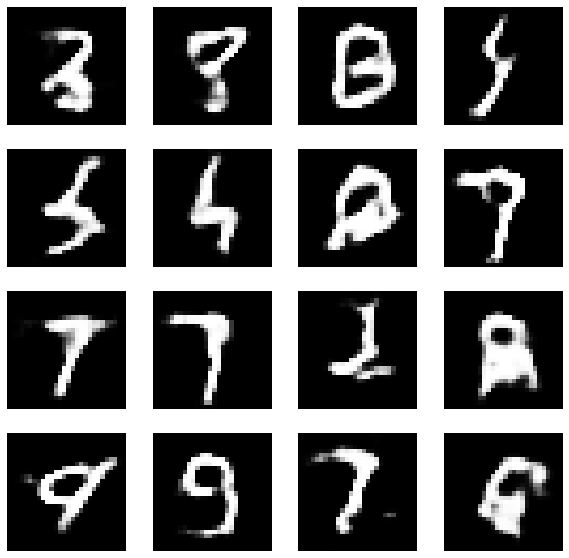

Época:  95


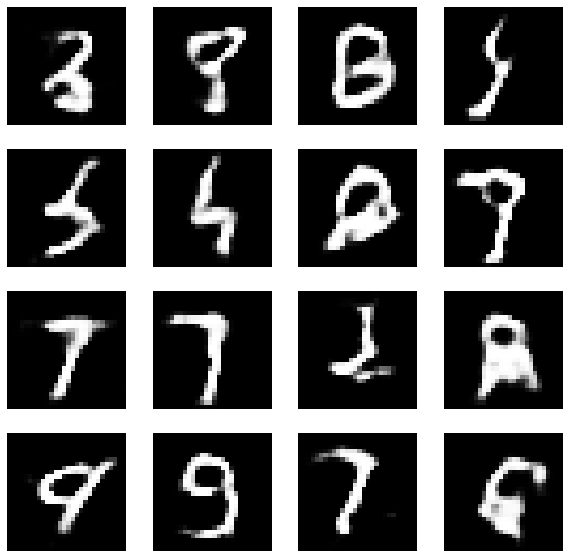

Época:  96


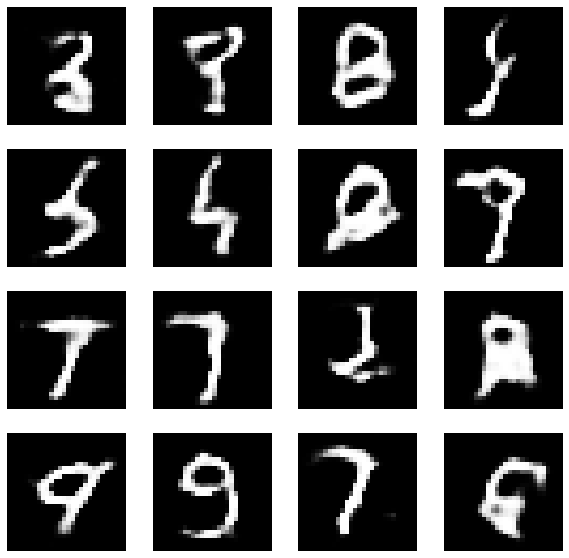

Época:  97


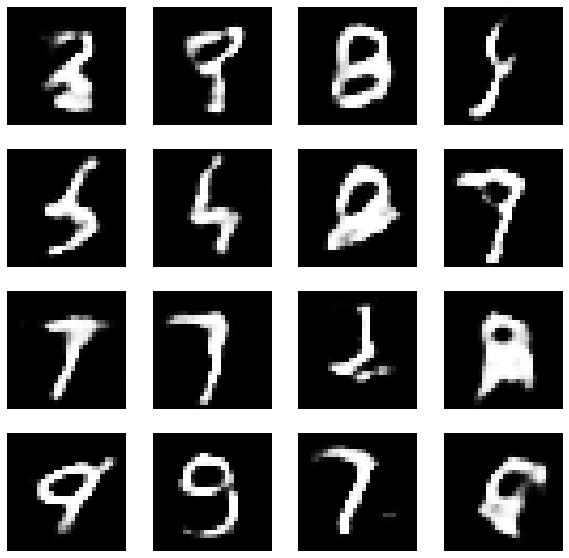

Época:  98


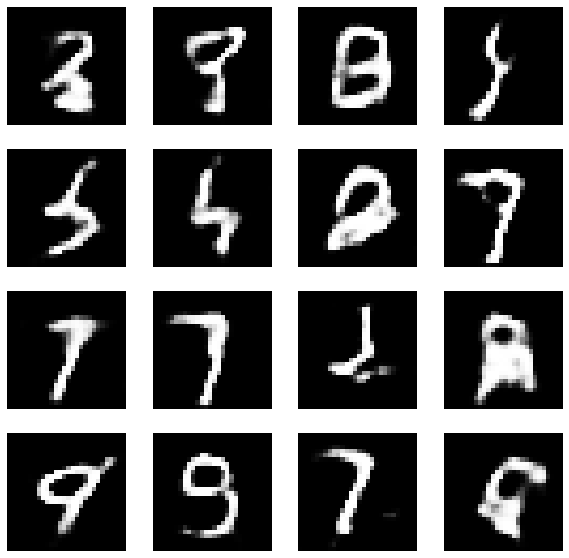

Época:  99


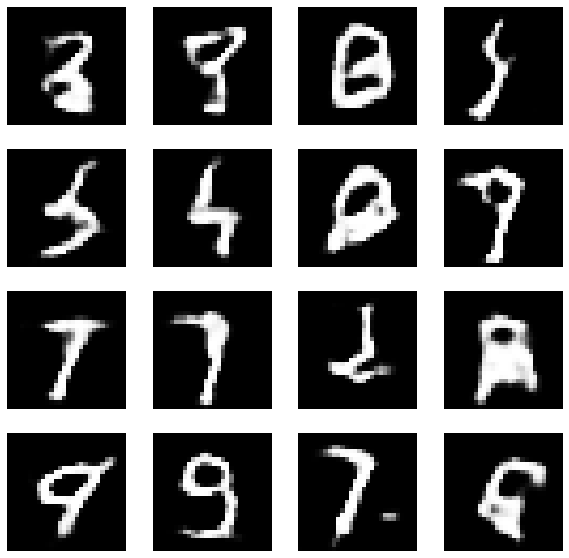

Época:  100


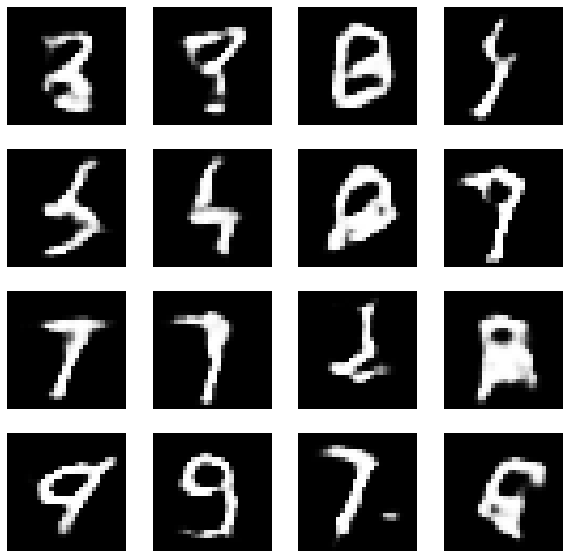

: 

In [46]:
treina_gan(X_treinamento, epocas, imagens_teste)